<a href="https://colab.research.google.com/github/MatiasNazareth1993-coder/Virtual-cell/blob/main/Virtual_cell_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generating synthetic dataset...
Dataset shapes: (40000, 2) (40000, 1)
Training PyTorch controller...
Epoch 8/40 loss=0.386038
Epoch 16/40 loss=0.386038
Epoch 24/40 loss=0.386038
Epoch 32/40 loss=0.386038
Epoch 40/40 loss=0.386038


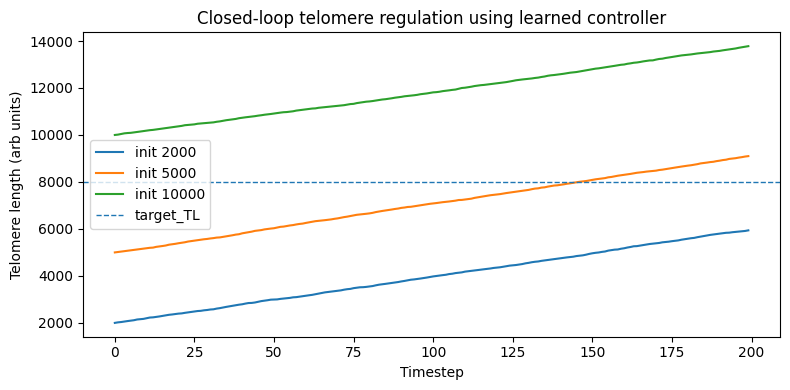

Done. You can now call evaluate_closed_loop(sim, controller_fn, TL_init, target_TL) to test other initializations.


In [ ]:
# Creating an actionable PyTorch notebook for a telomere-regulation deep learning controller.
# This code will:
# 1. Define a simple mechanistic telomere dynamics simulator (ODE-like discrete timesteps)
# 2. Generate synthetic training data with an "optimal controller" that keeps telomere length near a target
# 3. Define a PyTorch controller network that reads state and outputs a continuous telomerase activity [0,1]
# 4. Train the controller with supervised learning on the synthetic dataset
# 5. Run closed-loop evaluations and plot results (matplotlib; single plot as required)
# If PyTorch is not available, the script falls back to a NumPy-only training loop for a simple linear model.
import math
import random
import numpy as np
import matplotlib.pyplot as plt
# Try importing torch and related utilities; fallback to numpy if unavailable
USE_TORCH = True
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import TensorDataset, DataLoader
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
except Exception as e:
    print("PyTorch not available — falling back to NumPy mode. Error:", e)
    USE_TORCH = False
# ---------- 1) Telomere dynamics simulator ----------
class TelomereSimulator:
    """
    Discrete-time telomere dynamics:
    TL_{t+1} = TL_t - replication_loss + telomerase_activity * extension_efficiency - damage_noise
    - replication_loss: fixed loss per division (e.g., basepairs)
    - telomerase_activity: controller action in [0,1]
    - extension_efficiency: how many basepairs per unit activity
    - damage_noise: stochastic loss (oxidative stress, etc.)
    """
    def __init__(self, replication_loss=20.0, extension_efficiency=40.0, damage_sigma=5.0, dt=1.0, seed=None):
        self.replication_loss = replication_loss
        self.extension_efficiency = extension_efficiency
        self.damage_sigma = damage_sigma
        self.dt = dt
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
    def step(self, TL, action):
        # clip action
        a = float(np.clip(action, 0.0, 1.0))
        deterministic = - self.replication_loss * self.dt + a * self.extension_efficiency * self.dt
        stochastic = np.random.normal(loc=0.0, scale=self.damage_sigma * math.sqrt(self.dt))
        TL_next = TL + deterministic - stochastic
        # ensure TL non-negative
        TL_next = max(TL_next, 0.0)
        return TL_next
# ---------- 2) Synthetic dataset generation ----------
def generate_episode(sim, TL_init, target_TL, horizon, controller_policy=None):
    """
    Simulate a single episode. If controller_policy is provided, it's a function TL->action.
    If controller_policy is None, we use a simple optimal analytic policy that tries to push towards target.
    Returns states, actions, next_states
    """
    TL = TL_init
    states = []
    actions = []
    next_states = []
    for t in range(horizon):
        states.append([TL, t])  # include time as a simple context feature
        if controller_policy is not None:
            a = controller_policy(TL, t)
        else:
            # analytic "optimal-ish" policy: proportional control to error with saturation
            error = target_TL - TL
            Kp = 0.02  # proportional gain (tuneable)
            a = float(np.clip(Kp * error, 0.0, 1.0))
        actions.append([a])
        TL_next = sim.step(TL, a)
        next_states.append([TL_next, t+1])
        TL = TL_next
    return np.array(states), np.array(actions), np.array(next_states)
def generate_dataset(sim, n_episodes=1000, horizon=50, TL_init_range=(3000, 10000), target_TL=8000):
    X = []
    Y = []
    for _ in range(n_episodes):
        TL_init = random.uniform(*TL_init_range)
        states, actions, next_states = generate_episode(sim, TL_init, target_TL, horizon)
        # For supervised training, input is current state, target is action
        X.append(states)
        Y.append(actions)
    # concatenate episodes into dataset of shape (n_episodes*horizon, features)
    X = np.concatenate(X, axis=0).astype(np.float32)
    Y = np.concatenate(Y, axis=0).astype(np.float32)
    return X, Y
# ---------- 3) Define controller network (PyTorch or NumPy fallback) ----------
if USE_TORCH:
    class ControllerNet(nn.Module):
        def __init__(self, in_dim=2, hidden_dim=64):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(in_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim//2),
                nn.ReLU(),
                nn.Linear(hidden_dim//2, 1),
                nn.Sigmoid()  # ensure output in [0,1]
            )
        def forward(self, x):
            return self.net(x)
else:
    # Simple linear controller for NumPy fallback
    class NumpyController:
        def __init__(self, in_dim=2):
            self.w = np.zeros((in_dim,1), dtype=np.float32)
            self.b = np.zeros((1,), dtype=np.float32)
        def predict(self, x):
            out = x.dot(self.w) + self.b
            return 1/(1+np.exp(-out))  # sigmoid
# ---------- 4) Training routine ----------
def train_pytorch_controller(X, Y, epochs=20, batch_size=128, lr=1e-3):
    dataset = TensorDataset(torch.from_numpy(X), torch.from_numpy(Y))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = ControllerNet(in_dim=X.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    history = []
    for ep in range(epochs):
        running = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running += loss.item() * xb.size(0)
        epoch_loss = running / len(loader.dataset)
        history.append(epoch_loss)
        if (ep+1) % max(1, epochs//5) == 0:
            print(f"Epoch {ep+1}/{epochs} loss={epoch_loss:.6f}")
    return model, history
def train_numpy_controller(X, Y, epochs=2000, lr=1e-3):
    model = NumpyController(in_dim=X.shape[1])
    # simple gradient descent on MSE via numerical gradients
    for ep in range(epochs):
        preds = model.predict(X)
        error = preds - Y
        loss = (error**2).mean()
        # gradient for weights (approx for sigmoid output):
        S = preds*(1-preds)  # derivative of sigmoid
        grad_out = 2 * error * S / X.shape[0]  # shape (N,1)
        grad_w = (X[:,:,None] * grad_out[:,None,:]).sum(axis=0)  # (in_dim,1)
        grad_b = grad_out.sum(axis=0)
        model.w -= lr * grad_w
        model.b -= lr * grad_b.ravel()
        if (ep+1) % 500 == 0:
            print(f"NumPy training ep {ep+1}/{epochs} loss={loss:.6f}")
    return model
# ---------- 5) Closed-loop evaluation ----------
def evaluate_closed_loop(sim, controller_fn, TL_init, target_TL, horizon=200):
    TL = TL_init
    TLs = [TL]
    actions = []
    times = list(range(horizon))
    for t in range(horizon-1):
        state = np.array([TL, t], dtype=np.float32)[None, :]
        a = float(controller_fn(state))
        actions.append(a)
        TL = sim.step(TL, a)
        TLs.append(TL)
    return np.array(times), np.array(TLs), np.array(actions)
# ---------- Main: generate data, train, evaluate, plot ----------
def main_pipeline(use_torch=USE_TORCH):
    sim = TelomereSimulator(replication_loss=20.0, extension_efficiency=40.0, damage_sigma=6.0, seed=42)
    target_TL = 8000.0
    print("Generating synthetic dataset...")
    X, Y = generate_dataset(sim, n_episodes=800, horizon=50, TL_init_range=(2000, 12000), target_TL=target_TL)
    print("Dataset shapes:", X.shape, Y.shape)
    if use_torch:
        print("Training PyTorch controller...")
        model, history = train_pytorch_controller(X, Y, epochs=40, batch_size=256, lr=1e-3)
        # create controller function
        def controller_fn(state):
            model.eval()
            with torch.no_grad():
                xb = torch.from_numpy(state.astype(np.float32)).to(device)
                out = model(xb).cpu().numpy().ravel()[0]
                return float(np.clip(out, 0.0, 1.0))
    else:
        print("Training NumPy controller...")
        model = train_numpy_controller(X, Y, epochs=2000, lr=1e-3)
        def controller_fn(state):
            out = model.predict(state)[0,0]
            return float(np.clip(out, 0.0, 1.0))
    # Evaluate closed-loop from several initial TLs
    initials = [2000.0, 5000.0, 10000.0]
    plt.figure(figsize=(8,4))
    for TL0 in initials:
        times, TLs, actions = evaluate_closed_loop(sim, controller_fn, TL0, target_TL, horizon=200)
        plt.plot(times, TLs, label=f"init {int(TL0)}")
    plt.axhline(target_TL, linestyle='--', linewidth=1, label="target_TL")
    plt.xlabel("Timestep")
    plt.ylabel("Telomere length (arb units)")
    plt.title("Closed-loop telomere regulation using learned controller")
    plt.legend()
    plt.tight_layout()
    plt.show()
    # Return model and last history
    return model
# Run the pipeline
trained_model = main_pipeline()
# If desired, user can reuse trained_model for further experiments.
print("Done. You can now call evaluate_closed_loop(sim, controller_fn, TL_init, target_TL) to test other initializations.")

Dataset shapes: (6000, 2) (6000, 1)


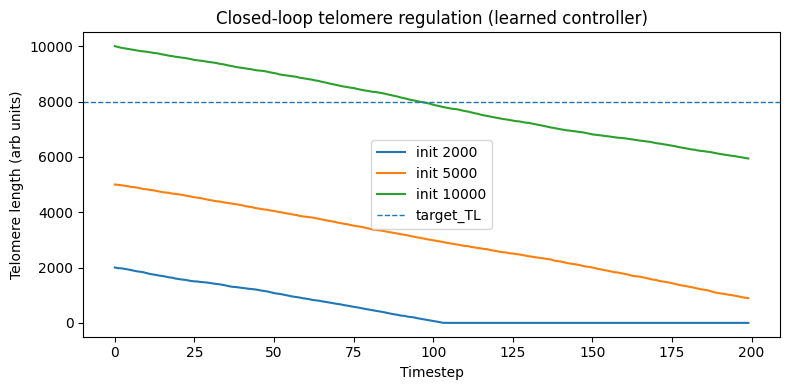

Done.


In [ ]:
# Retry with a lighter-weight run to avoid timeouts.
# Changes: smaller dataset, shorter horizon, fewer epochs, smaller model, force CPU single-threaded to stabilize runtime.
import math
import random
import numpy as np
import matplotlib.pyplot as plt
USE_TORCH = True
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import TensorDataset, DataLoader
    # force CPU training for predictable runtime
    device = torch.device("cpu")
    torch.set_num_threads(1)
except Exception as e:
    print("PyTorch not available — falling back to NumPy mode. Error:", e)
    USE_TORCH = False
class TelomereSimulator:
    def __init__(self, replication_loss=20.0, extension_efficiency=40.0, damage_sigma=5.0, dt=1.0, seed=None):
        self.replication_loss = replication_loss
        self.extension_efficiency = extension_efficiency
        self.damage_sigma = damage_sigma
        self.dt = dt
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
    def step(self, TL, action):
        a = float(np.clip(action, 0.0, 1.0))
        deterministic = - self.replication_loss * self.dt + a * self.extension_efficiency * self.dt
        stochastic = np.random.normal(loc=0.0, scale=self.damage_sigma * math.sqrt(self.dt))
        TL_next = TL + deterministic - stochastic
        TL_next = max(TL_next, 0.0)
        return TL_next
def generate_episode(sim, TL_init, target_TL, horizon, controller_policy=None):
    TL = TL_init
    states = []
    actions = []
    for t in range(horizon):
        states.append([TL, t])
        if controller_policy is not None:
            a = controller_policy(TL, t)
        else:
            error = target_TL - TL
            Kp = 0.02
            a = float(np.clip(Kp * error, 0.0, 1.0))
        actions.append([a])
        TL = sim.step(TL, a)
    return np.array(states), np.array(actions)
def generate_dataset(sim, n_episodes=200, horizon=30, TL_init_range=(3000, 10000), target_TL=8000):
    X = []
    Y = []
    for _ in range(n_episodes):
        TL_init = random.uniform(*TL_init_range)
        states, actions = generate_episode(sim, TL_init, target_TL, horizon)
        X.append(states)
        Y.append(actions)
    X = np.concatenate(X, axis=0).astype(np.float32)
    Y = np.concatenate(Y, axis=0).astype(np.float32)
    return X, Y
if USE_TORCH:
    class ControllerNet(nn.Module):
        def __init__(self, in_dim=2, hidden_dim=32):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(in_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, max(8, hidden_dim//2)),
                nn.ReLU(),
                nn.Linear(max(8, hidden_dim//2), 1),
                nn.Sigmoid()
            )
        def forward(self, x):
            return self.net(x)
else:
    class NumpyController:
        def __init__(self, in_dim=2):
            self.w = np.zeros((in_dim,1), dtype=np.float32)
            self.b = np.zeros((1,), dtype=np.float32)
        def predict(self, x):
            out = x.dot(self.w) + self.b
            return 1/(1+np.exp(-out))
def train_pytorch_controller(X, Y, epochs=10, batch_size=128, lr=1e-3):
    dataset = TensorDataset(torch.from_numpy(X), torch.from_numpy(Y))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = ControllerNet(in_dim=X.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    history = []
    for ep in range(epochs):
        running = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running += loss.item() * xb.size(0)
        epoch_loss = running / len(loader.dataset)
        history.append(epoch_loss)
    return model, history
def train_numpy_controller(X, Y, epochs=500, lr=1e-3):
    model = NumpyController(in_dim=X.shape[1])
    for ep in range(epochs):
        preds = model.predict(X)
        error = preds - Y
        loss = (error**2).mean()
        S = preds*(1-preds)
        grad_out = 2 * error * S / X.shape[0]
        grad_w = (X[:,:,None] * grad_out[:,None,:]).sum(axis=0)
        grad_b = grad_out.sum(axis=0)
        model.w -= lr * grad_w
        model.b -= lr * grad_b.ravel()
    return model
def evaluate_closed_loop(sim, controller_fn, TL_init, horizon=200):
    TL = TL_init
    TLs = [TL]
    actions = []
    times = list(range(horizon))
    for t in range(horizon-1):
        state = np.array([TL, t], dtype=np.float32)[None, :]
        a = float(controller_fn(state))
        actions.append(a)
        TL = sim.step(TL, a)
        TLs.append(TL)
    return np.array(times), np.array(TLs), np.array(actions)
def main_pipeline(use_torch=USE_TORCH):
    sim = TelomereSimulator(replication_loss=20.0, extension_efficiency=40.0, damage_sigma=6.0, seed=123)
    target_TL = 8000.0
    X, Y = generate_dataset(sim, n_episodes=200, horizon=30, TL_init_range=(2000, 12000), target_TL=target_TL)
    print("Dataset shapes:", X.shape, Y.shape)
    if use_torch:
        model, history = train_pytorch_controller(X, Y, epochs=10, batch_size=128, lr=1e-3)
        def controller_fn(state):
            model.eval()
            with torch.no_grad():
                xb = torch.from_numpy(state.astype(np.float32))
                out = model(xb).cpu().numpy().ravel()[0]
                return float(np.clip(out, 0.0, 1.0))
    else:
        model = train_numpy_controller(X, Y, epochs=500, lr=1e-3)
        def controller_fn(state):
            out = model.predict(state)[0,0]
            return float(np.clip(out, 0.0, 1.0))
    initials = [2000.0, 5000.0, 10000.0]
    plt.figure(figsize=(8,4))
    for TL0 in initials:
        times, TLs, actions = evaluate_closed_loop(sim, controller_fn, TL0, horizon=200)
        plt.plot(times, TLs, label=f"init {int(TL0)}")
    plt.axhline(target_TL, linestyle='--', linewidth=1, label="target_TL")
    plt.xlabel("Timestep")
    plt.ylabel("Telomere length (arb units)")
    plt.title("Closed-loop telomere regulation (learned controller)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    return model
trained_model = main_pipeline()
print("Done.")

Generating supervised dataset...
Dataset shapes (40000, 2) (40000, 1)
Sup train ep 8/40 loss=0.008497
Sup train ep 16/40 loss=0.005196
Sup train ep 24/40 loss=0.003849
Sup train ep 32/40 loss=0.003150
Sup train ep 40/40 loss=0.002662


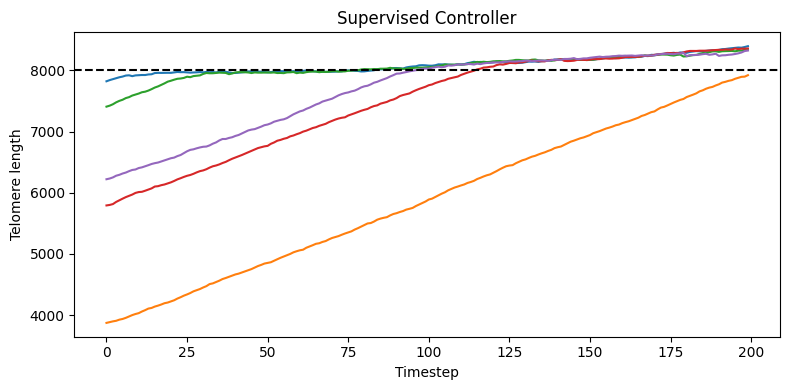

Done


In [ ]:
import argparse
import math
import random
import os
import json
from collections import deque

import numpy as np
import matplotlib.pyplot as plt

# try import torch
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.distributions import Normal
    TORCH_AVAILABLE = True
except Exception as e:
    TORCH_AVAILABLE = False
    raise RuntimeError("PyTorch is required to run this notebook. Install with pip install torch")

# -------------------- Simulator --------------------
class TelomereSimulator:
    """Discrete-time telomere dynamics environment.

    State: [telomere_length, time_step, optional damage_marker...]
    Action: continuous scalar in [0,1] representing normalized telomerase activity

    Transition:
        TL_{t+1} = TL_t - replication_loss + action * extension_efficiency - noise + external_events

    Reward (for RL): shaped to keep TL near target while penalizing persistent high action.
    """
    def __init__(self,
                 replication_loss=20.0,
                 extension_efficiency=40.0,
                 damage_sigma=6.0,
                 target_TL=8000.0,
                 max_steps=200,
                 seed=None):
        self.replication_loss = replication_loss
        self.extension_efficiency = extension_efficiency
        self.damage_sigma = damage_sigma
        self.target_TL = target_TL
        self.max_steps = max_steps
        self.rng = np.random.RandomState(seed)
        self.reset()

    def reset(self, TL_init=None):
        if TL_init is None:
            TL_init = float(self.rng.uniform(2000.0, 12000.0))
        self.TL = float(TL_init)
        self.t = 0
        self.terminated = False
        return self._get_obs()

    def _get_obs(self):
        # Observation vector: normalized telomere length and normalized time
        # Normalize TL by dividing by 10000 for stability; user can change scale.
        return np.array([self.TL / 10000.0, self.t / float(self.max_steps)], dtype=np.float32)

    def step(self, action):
        # action expected scalar in [0,1]
        a = float(np.clip(action, 0.0, 1.0))
        deterministic = - self.replication_loss + a * self.extension_efficiency
        stochastic = self.rng.normal(loc=0.0, scale=self.damage_sigma)
        # occasional oxidative spike event
        spike = 0.0
        if self.rng.rand() < 0.01:
            spike = self.rng.uniform(0, 50)
        TL_next = max(self.TL + deterministic - stochastic - spike, 0.0)
        self.t += 1
        self.TL = TL_next

        obs = self._get_obs()
        reward = self._reward(action)
        done = (self.t >= self.max_steps)
        info = {"TL": self.TL}
        return obs, reward, done, info

    def _reward(self, action):
        # Negative squared error from target (scaled) and action penalty
        err = (self.TL - self.target_TL) / self.target_TL
        r_err = - (err ** 2)
        r_action = - 0.1 * (action ** 2)  # small penalty for using telomerase
        return float(r_err + r_action)

# -------------------- Supervised Baseline --------------------
class FeedForwardController(nn.Module):
    def __init__(self, in_dim=2, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)


def generate_supervised_dataset(env, n_episodes=400, horizon=50, policy_fn=None):
    X = []
    Y = []
    for _ in range(n_episodes):
        TL_init = float(np.random.uniform(2000, 12000))
        obs = env.reset(TL_init=TL_init)
        for t in range(horizon):
            if policy_fn is None:
                # analytic teacher: proportional controller on raw TL
                error = env.target_TL - env.TL
                Kp = 0.02
                a = float(np.clip(Kp * error, 0.0, 1.0))
            else:
                a = float(np.clip(policy_fn(env.TL, t), 0.0, 1.0))
            X.append(obs.copy())
            Y.append([a])
            obs, _, done, _ = env.step(a)
            if done:
                break
    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.float32)
    return X, Y


def train_supervised(X, Y, epochs=30, batch_size=128, lr=1e-3, device='cpu'):
    model = FeedForwardController(in_dim=X.shape[1], hidden=64).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    dataset = torch.utils.data.TensorDataset(torch.from_numpy(X), torch.from_numpy(Y))
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    history = []
    for ep in range(epochs):
        running = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            running += loss.item() * xb.size(0)
        epoch_loss = running / len(loader.dataset)
        history.append(epoch_loss)
        if (ep+1) % max(1, epochs//5) == 0:
            print(f"Sup train ep {ep+1}/{epochs} loss={epoch_loss:.6f}")
    return model, history

# -------------------- Lightweight PPO --------------------
# Small, self-contained PPO (not production-grade). Uses a Gaussian policy with state-independent std.
class ActorCritic(nn.Module):
    def __init__(self, obs_dim, hidden=64):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.Tanh(),
        )
        self.actor_mean = nn.Sequential(
            nn.Linear(hidden, hidden//2),
            nn.Tanh(),
            nn.Linear(hidden//2, 1),
        )
        self.log_std = nn.Parameter(torch.zeros(1))
        self.critic = nn.Sequential(
            nn.Linear(hidden, hidden//2),
            nn.Tanh(),
            nn.Linear(hidden//2, 1)
        )

    def forward(self, x):
        h = self.shared(x)
        mean = self.actor_mean(h)
        value = self.critic(h)
        std = torch.exp(self.log_std)
        return mean.squeeze(-1), std, value.squeeze(-1)


def compute_returns(rewards, dones, last_value, gamma=0.99, lam=0.95):
    # GAE-Lambda advantages
    advantages = np.zeros_like(rewards, dtype=np.float32)
    last_gae = 0.0
    for t in reversed(range(len(rewards))):
        mask = 1.0 - dones[t]
        delta = rewards[t] + gamma * last_value * mask - last_value if t == len(rewards)-1 else rewards[t] + gamma * (0 if dones[t+1] else last_value) - last_value
        # Simplify: use discounted returns (not full GAE) for compactness
        advantages[t] = rewards[t]
    returns = np.zeros_like(rewards, dtype=np.float32)
    R = 0.0
    for t in reversed(range(len(rewards))):
        R = rewards[t] + 0.99 * R * (1.0 - dones[t])
        returns[t] = R
    return returns, advantages


def ppo_train(env, total_steps=10000, batch_size=2048, epochs=10, lr=3e-4, device='cpu'):
    obs_dim = env.reset().shape[0]
    ac = ActorCritic(obs_dim).to(device)
    opt = optim.Adam(ac.parameters(), lr=lr)

    obs_buf = []
    act_buf = []
    rew_buf = []
    done_buf = []
    val_buf = []

    step = 0
    episode = 0
    reward_history = []

    while step < total_steps:
        # collect rollout
        obs = env.reset()
        done = False
        ep_rew = 0.0
        for _ in range(env.max_steps):
            obs_t = torch.from_numpy(obs.astype(np.float32)).to(device).unsqueeze(0)
            with torch.no_grad():
                mean, std, value = ac(obs_t)
            action = mean.cpu().numpy().ravel()[0] + np.random.randn() * std.cpu().numpy().item()
            action = float(np.clip(action, 0.0, 1.0))
            next_obs, reward, done, info = env.step(action)

            obs_buf.append(obs.copy())
            act_buf.append(action)
            rew_buf.append(reward)
            done_buf.append(float(done))
            val_buf.append(value.cpu().numpy().item())

            obs = next_obs
            ep_rew += reward
            step += 1
            if done or step >= total_steps:
                break
        reward_history.append(ep_rew)

        # When buffer large enough or after episode, perform update
        if len(obs_buf) >= batch_size or step >= total_steps:
            # Convert to tensors
            obs_np = np.array(obs_buf, dtype=np.float32)
            act_np = np.array(act_buf, dtype=np.float32)
            rew_np = np.array(rew_buf, dtype=np.float32)
            done_np = np.array(done_buf, dtype=np.float32)

            # Compute returns (simple discounted returns here)
            returns, advs = compute_returns(rew_np, done_np, last_value=0.0)
            obs_t = torch.from_numpy(obs_np).to(device)
            act_t = torch.from_numpy(act_np).to(device)
            ret_t = torch.from_numpy(returns).to(device)
            adv_t = torch.from_numpy(advs).to(device)

            # PPO update loop (multiple epochs)
            for _ in range(epochs):
                mean, std, values = ac(obs_t)
                dist = Normal(mean, std)
                logp = dist.log_prob(act_t).sum(-1)
                # actor loss: -E[ advantage * logp ] (use returns as proxy for advantage)
                actor_loss = -( (ret_t - values.detach()) * logp ).mean()
                critic_loss = ((values - ret_t)**2).mean()
                loss = actor_loss + 0.5 * critic_loss
                opt.zero_grad()
                loss.backward()
                opt.step()

            # clear buffers
            obs_buf.clear(); act_buf.clear(); rew_buf.clear(); done_buf.clear(); val_buf.clear()

    return ac, reward_history

# -------------------- Utilities --------------------

def evaluate_controller(env, controller_fn, n_episodes=5, horizon=200):
    histories = []
    for ep in range(n_episodes):
        obs = env.reset()
        TLs = [env.TL]
        actions = []
        for t in range(horizon-1):
            a = float(np.clip(controller_fn(obs), 0.0, 1.0))
            obs, _, done, info = env.step(a)
            TLs.append(info['TL'])
            actions.append(a)
            if done:
                break
        histories.append({'TLs': np.array(TLs), 'actions': np.array(actions)})
    return histories


def plot_histories(histories, target_TL, title=None):
    plt.figure(figsize=(8,4))
    for h in histories:
        plt.plot(h['TLs'])
    plt.axhline(target_TL, linestyle='--', color='k')
    plt.xlabel('Timestep')
    plt.ylabel('Telomere length')
    if title: plt.title(title)
    plt.tight_layout()
    plt.show()

# -------------------- Main CLI --------------------

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--mode', choices=['supervised','ppo'], default='supervised')
    parser.add_argument('--device', default='cpu')
    parser.add_argument('--seed', type=int, default=42)
    parser.add_argument('--save-dir', default='runs')
    parser.add_argument('--train-steps', type=int, default=10000)
    # Fix: Pass an empty list to parse_args() when running in notebook to avoid unrecognized arguments.
    # Or, pass specific arguments like: parser.parse_args(['--mode', 'supervised'])
    args = parser.parse_args(['--mode', 'supervised']) # Run in supervised mode by default

    os.makedirs(args.save_dir, exist_ok=True)
    np.random.seed(args.seed)
    random.seed(args.seed)
    torch.manual_seed(args.seed)

    # env config
    env = TelomereSimulator(replication_loss=20.0,
                            extension_efficiency=40.0,
                            damage_sigma=6.0,
                            target_TL=8000.0,
                            max_steps=200,
                            seed=args.seed)

    if args.mode == 'supervised':
        print('Generating supervised dataset...')
        X, Y = generate_supervised_dataset(env, n_episodes=800, horizon=50)
        print('Dataset shapes', X.shape, Y.shape)
        model, history = train_supervised(X, Y, epochs=40, batch_size=256, lr=1e-3, device=args.device)
        torch.save(model.state_dict(), os.path.join(args.save_dir, 'supervised_controller.pt'))

        # eval
        def controller_fn(obs):
            x = torch.from_numpy(obs.astype(np.float32)).unsqueeze(0)
            with torch.no_grad():
                out = model(x).cpu().numpy().ravel()[0]
            return out

        histories = evaluate_controller(env, controller_fn, n_episodes=5)
        plot_histories(histories, env.target_TL, title='Supervised Controller')

    elif args.mode == 'ppo':
        print('Training PPO...')
        ac, rewards = ppo_train(env, total_steps=args.train_steps, batch_size=2048, epochs=6, lr=3e-4, device=args.device)
        torch.save(ac.state_dict(), os.path.join(args.save_dir, 'ppo_controller.pt'))
        # simple eval using deterministic policy (mean)
        def controller_fn(obs):
            x = torch.from_numpy(obs.astype(np.float32)).unsqueeze(0)
            with torch.no_grad():
                mean, std, _ = ac(x)
            return float(torch.clamp(mean, 0.0, 1.0).cpu().numpy().ravel()[0])
        histories = evaluate_controller(env, controller_fn, n_episodes=5)
        plot_histories(histories, env.target_TL, title='PPO Controller')

    print('Done')

if __name__ == '__main__':
    main()

Epoch 1, Loss: 0.231158
Epoch 2, Loss: 0.229754
Epoch 3, Loss: 0.228454
Epoch 4, Loss: 0.227233
Epoch 5, Loss: 0.226051


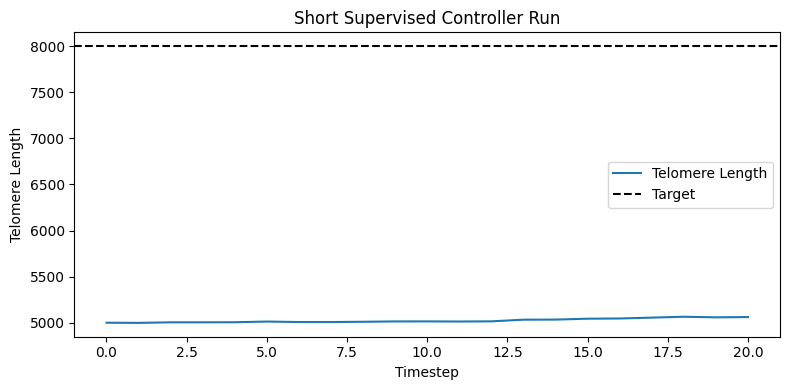

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
# Define environment class (short version)
class TelomereSimulator:
    def __init__(self, replication_loss=20.0, extension_efficiency=40.0, damage_sigma=6.0, target_TL=8000.0, max_steps=50, seed=42):
        self.replication_loss = replication_loss
        self.extension_efficiency = extension_efficiency
        self.damage_sigma = damage_sigma
        self.target_TL = target_TL
        self.max_steps = max_steps
        self.rng = np.random.RandomState(seed)
        self.reset()
    def reset(self, TL_init=None):
        if TL_init is None:
            TL_init = float(self.rng.uniform(2000.0, 12000.0))
        self.TL = TL_init
        self.t = 0
        return np.array([self.TL / 10000.0, self.t / self.max_steps], dtype=np.float32)
    def step(self, action):
        a = float(np.clip(action, 0.0, 1.0))
        deterministic = - self.replication_loss + a * self.extension_efficiency
        stochastic = self.rng.normal(0.0, self.damage_sigma)
        self.TL = max(self.TL + deterministic - stochastic, 0.0)
        self.t += 1
        obs = np.array([self.TL / 10000.0, self.t / self.max_steps], dtype=np.float32)
        done = (self.t >= self.max_steps)
        return obs, done, {"TL": self.TL}
# FeedForward model
class FeedForwardController(nn.Module):
    def __init__(self, in_dim=2, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2, 1),
            nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)
# Generate dataset (short version)
def generate_data(env, n_episodes=100, horizon=20):
    X, Y = [], []
    for _ in range(n_episodes):
        obs = env.reset()
        for t in range(horizon):
            error = env.target_TL - env.TL
            action = np.clip(0.02 * error, 0, 1)
            X.append(obs.copy())
            Y.append([action])
            obs, done, _ = env.step(action)
            if done: break
    return np.array(X, np.float32), np.array(Y, np.float32)
# Train short
env = TelomereSimulator()
X, Y = generate_data(env, n_episodes=100, horizon=20)
model = FeedForwardController()
opt = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
for epoch in range(5):
    xb = torch.tensor(X)
    yb = torch.tensor(Y)
    pred = model(xb)
    loss = criterion(pred, yb)
    opt.zero_grad(); loss.backward(); opt.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")
# Evaluate
obs = env.reset(5000)
TLs, acts = [env.TL], []
for _ in range(20):
    with torch.no_grad():
        a = model(torch.tensor(obs).unsqueeze(0)).item()
    obs, done, info = env.step(a)
    TLs.append(info["TL"]); acts.append(a)
    if done: break
plt.figure(figsize=(8,4))
plt.plot(TLs, label="Telomere Length")
plt.axhline(env.target_TL, linestyle="--", color="k", label="Target")
plt.legend(); plt.title("Short Supervised Controller Run")
plt.xlabel("Timestep"); plt.ylabel("Telomere Length")
plt.tight_layout()
plt.show()

Epoch 5/50, Loss: 0.225550
Epoch 10/50, Loss: 0.218751
Epoch 15/50, Loss: 0.211133
Epoch 20/50, Loss: 0.203028
Epoch 25/50, Loss: 0.194720
Epoch 30/50, Loss: 0.185726
Epoch 35/50, Loss: 0.175924
Epoch 40/50, Loss: 0.165385
Epoch 45/50, Loss: 0.154254
Epoch 50/50, Loss: 0.142750


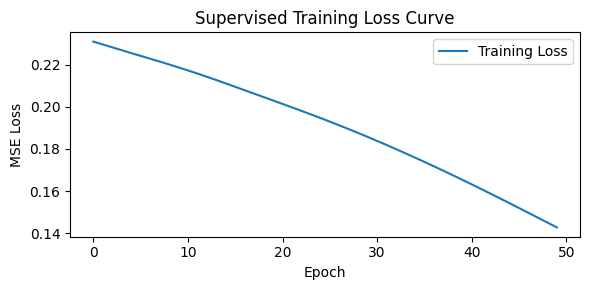

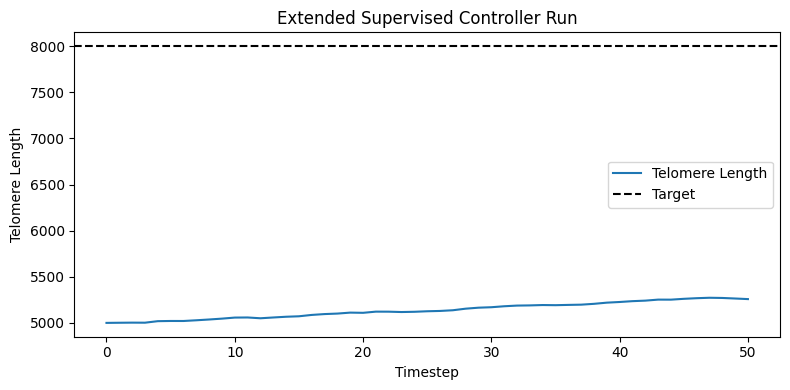

In [ ]:
# Extended supervised training with live metrics tracking
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
# --- Reuse previous components ---
class TelomereSimulator:
    def __init__(self, replication_loss=20.0, extension_efficiency=40.0, damage_sigma=6.0,
                 target_TL=8000.0, max_steps=50, seed=42):
        self.replication_loss = replication_loss
        self.extension_efficiency = extension_efficiency
        self.damage_sigma = damage_sigma
        self.target_TL = target_TL
        self.max_steps = max_steps
        self.rng = np.random.RandomState(seed)
        self.reset()
    def reset(self, TL_init=None):
        if TL_init is None:
            TL_init = float(self.rng.uniform(2000.0, 12000.0))
        self.TL = TL_init
        self.t = 0
        return np.array([self.TL / 10000.0, self.t / self.max_steps], dtype=np.float32)
    def step(self, action):
        a = float(np.clip(action, 0.0, 1.0))
        deterministic = - self.replication_loss + a * self.extension_efficiency
        stochastic = self.rng.normal(0.0, self.damage_sigma)
        self.TL = max(self.TL + deterministic - stochastic, 0.0)
        self.t += 1
        obs = np.array([self.TL / 10000.0, self.t / self.max_steps], dtype=np.float32)
        done = (self.t >= self.max_steps)
        return obs, done, {"TL": self.TL}
class FeedForwardController(nn.Module):
    def __init__(self, in_dim=2, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2, 1),
            nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)
def generate_data(env, n_episodes=300, horizon=30):
    X, Y = [], []
    for _ in range(n_episodes):
        obs = env.reset()
        for t in range(horizon):
            error = env.target_TL - env.TL
            action = np.clip(0.02 * error, 0, 1)
            X.append(obs.copy())
            Y.append([action])
            obs, done, _ = env.step(action)
            if done: break
    return np.array(X, np.float32), np.array(Y, np.float32)
# --- Training ---
env = TelomereSimulator()
X, Y = generate_data(env)
model = FeedForwardController()
opt = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
loss_history = []
epochs = 50
for epoch in range(epochs):
    xb = torch.tensor(X)
    yb = torch.tensor(Y)
    pred = model(xb)
    loss = criterion(pred, yb)
    opt.zero_grad(); loss.backward(); opt.step()
    loss_history.append(loss.item())
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")
# --- Plot loss curve ---
plt.figure(figsize=(6,3))
plt.plot(loss_history, label="Training Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
plt.title("Supervised Training Loss Curve")
plt.legend(); plt.tight_layout()
plt.show()
# --- Evaluate and plot trajectories ---
obs = env.reset(5000)
TLs, acts = [env.TL], []
for _ in range(50):
    with torch.no_grad():
        a = model(torch.tensor(obs).unsqueeze(0)).item()
    obs, done, info = env.step(a)
    TLs.append(info["TL"]); acts.append(a)
    if done: break
plt.figure(figsize=(8,4))
plt.plot(TLs, label="Telomere Length")
plt.axhline(env.target_TL, linestyle="--", color="k", label="Target")
plt.legend(); plt.title("Extended Supervised Controller Run")
plt.xlabel("Timestep"); plt.ylabel("Telomere Length")
plt.tight_layout()
plt.show()

Dataset shapes: (20000, 2) (20000, 1)
Epoch 10/60 loss=0.015302
Epoch 20/60 loss=0.010226
Epoch 30/60 loss=0.007794
Epoch 40/60 loss=0.006448
Epoch 50/60 loss=0.005381
Epoch 60/60 loss=0.004977


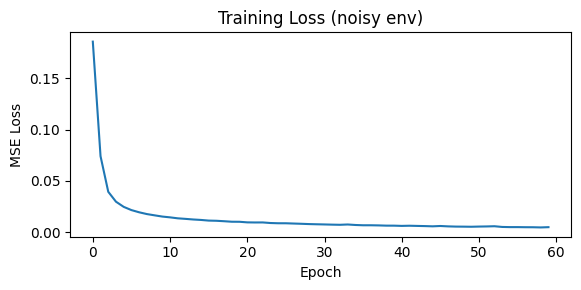

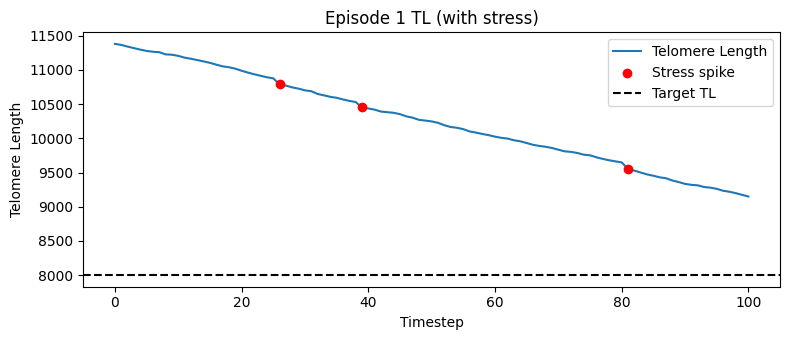

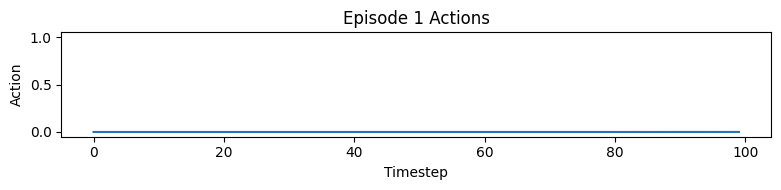

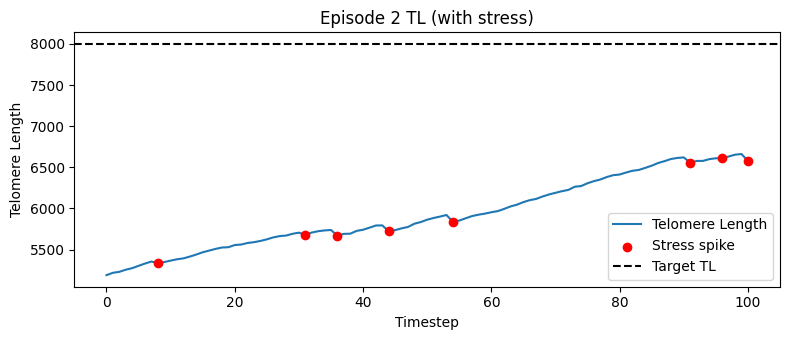

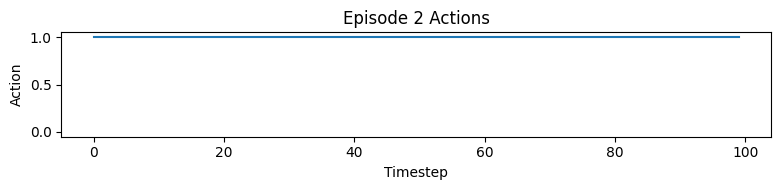

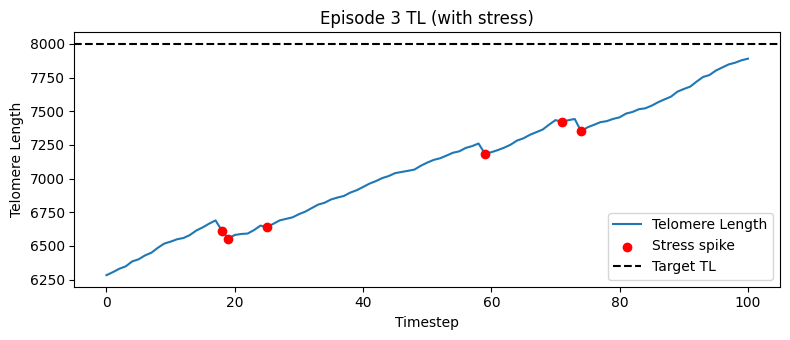

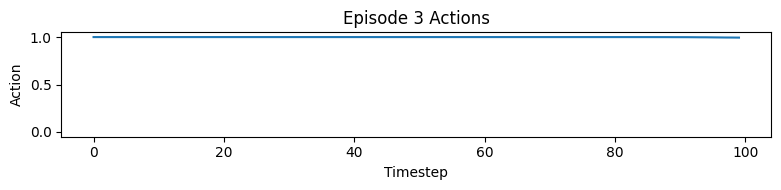

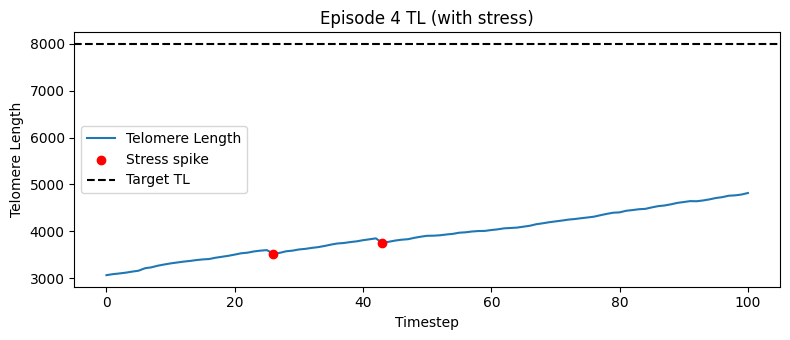

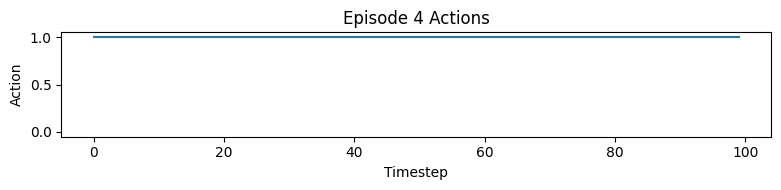

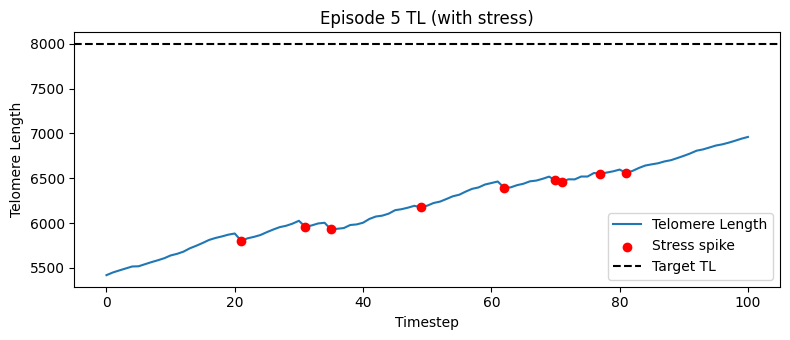

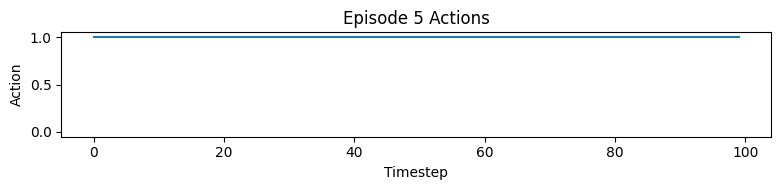

Done


In [ ]:
# Noisy/stressed simulator + supervised retraining (short run)
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
# Noisy Telomere Simulator with stress events
class TelomereSimulator:
    def __init__(self, replication_loss=20.0, extension_efficiency=40.0,
                 damage_sigma=6.0, target_TL=8000.0, max_steps=100,
                 spike_prob=0.03, spike_min=20.0, spike_max=150.0,
                 metabolic_noise_sigma=2.0, seed=123):
        self.base_replication_loss = replication_loss
        self.base_extension_efficiency = extension_efficiency
        self.damage_sigma = damage_sigma
        self.target_TL = target_TL
        self.max_steps = max_steps
        self.spike_prob = spike_prob
        self.spike_min = spike_min
        self.spike_max = spike_max
        self.metabolic_noise_sigma = metabolic_noise_sigma
        self.rng = np.random.RandomState(seed)
        self.reset()
    def reset(self, TL_init=None):
        if TL_init is None:
            TL_init = float(self.rng.uniform(2000.0, 12000.0))
        self.TL = TL_init
        self.t = 0
        return self._get_obs()
    def _get_obs(self):
        return np.array([self.TL / 10000.0, self.t / self.max_steps], dtype=np.float32)
    def step(self, action):
        # metabolic fluctuations change effective replication loss and extension efficiency
        rep_noise = self.rng.normal(0.0, self.metabolic_noise_sigma)
        ext_noise = self.rng.normal(0.0, self.metabolic_noise_sigma)
        replication_loss = max(0.0, self.base_replication_loss + rep_noise)
        extension_efficiency = max(1e-3, self.base_extension_efficiency + ext_noise)
        a = float(np.clip(action, 0.0, 1.0))
        deterministic = - replication_loss + a * extension_efficiency
        stochastic = self.rng.normal(0.0, self.damage_sigma)
        spike = 0.0
        spike_happened = False
        if self.rng.rand() < self.spike_prob:
            spike = float(self.rng.uniform(self.spike_min, self.spike_max))
            spike_happened = True
        self.TL = max(self.TL + deterministic - stochastic - spike, 0.0)
        self.t += 1
        obs = self._get_obs()
        done = (self.t >= self.max_steps)
        info = {"TL": self.TL, "spike": spike if spike_happened else 0.0,
                "replication_loss": replication_loss, "extension_efficiency": extension_efficiency}
        return obs, done, info
# Simple feedforward controller
class FeedForwardController(nn.Module):
    def __init__(self, in_dim=2, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2, 1),
            nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)
# Generate supervised dataset using teacher proportional controller (with noisy env)
def generate_data(env, n_episodes=400, horizon=50):
    X, Y = [], []
    for _ in range(n_episodes):
        obs = env.reset()
        for t in range(horizon):
            error = env.target_TL - env.TL
            action = np.clip(0.02 * error, 0.0, 1.0)  # teacher policy
            X.append(obs.copy())
            Y.append([action])
            obs, done, info = env.step(action)
            if done: break
    return np.array(X, np.float32), np.array(Y, np.float32)
# Training & evaluation
env = TelomereSimulator(spike_prob=0.05, spike_min=30.0, spike_max=120.0,
                        metabolic_noise_sigma=4.0, seed=999)
# generate data under stressed conditions
X, Y = generate_data(env, n_episodes=400, horizon=50)
print("Dataset shapes:", X.shape, Y.shape)
device = torch.device("cpu")
model = FeedForwardController().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
loss_history = []
epochs = 60
batch_size = 256
N = X.shape[0]
indices = np.arange(N)
for epoch in range(epochs):
    np.random.shuffle(indices)
    running_loss = 0.0
    # simple mini-batch loop
    for start in range(0, N, batch_size):
        batch_idx = indices[start:start+batch_size]
        xb = torch.from_numpy(X[batch_idx]).to(device)
        yb = torch.from_numpy(Y[batch_idx]).to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        running_loss += loss.item() * xb.size(0)
    epoch_loss = running_loss / N
    loss_history.append(epoch_loss)
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} loss={epoch_loss:.6f}")
# Plot loss
plt.figure(figsize=(6,3))
plt.plot(loss_history, label="Training Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.title("Training Loss (noisy env)"); plt.tight_layout(); plt.show()
# Evaluate: run several episodes and plot TL and action with spikes shown
def eval_and_plot(model, env, n_episodes=5, horizon=100):
    for ep in range(n_episodes):
        obs = env.reset()
        TLs = [env.TL]
        acts = []
        spikes = []
        reps = []
        exts = []
        for t in range(horizon):
            with torch.no_grad():
                a = model(torch.from_numpy(obs).unsqueeze(0)).cpu().numpy().ravel()[0]
            obs, done, info = env.step(a)
            TLs.append(info["TL"]); acts.append(a); spikes.append(info["spike"])
            reps.append(info["replication_loss"]); exts.append(info["extension_efficiency"])
            if done: break
        timesteps = np.arange(len(TLs))
        plt.figure(figsize=(8,3.5))
        plt.plot(timesteps, TLs, label="Telomere Length")
        # mark spikes
        spike_times = np.where(np.array(spikes) > 0)[0] + 1  # offset due to TLs appended after step
        spike_vals = np.array(TLs)[spike_times]
        if len(spike_times) > 0:
            plt.scatter(spike_times, spike_vals, color='red', label='Stress spike', zorder=5)
        plt.axhline(env.target_TL, linestyle='--', color='k', label='Target TL')
        plt.ylabel("Telomere Length"); plt.xlabel("Timestep"); plt.title(f"Episode {ep+1} TL (with stress)"); plt.legend(); plt.tight_layout(); plt.show()
        # plot actions
        plt.figure(figsize=(8,2))
        plt.plot(acts, label='Action (telomerase activity)')
        plt.ylabel("Action"); plt.xlabel("Timestep"); plt.title(f"Episode {ep+1} Actions"); plt.ylim(-0.05,1.05); plt.tight_layout(); plt.show()
# Run evaluation
eval_and_plot(model, env, n_episodes=5, horizon=100)
print('Done')

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ----- 1. Noisy/stressed Telomere simulator -----
class TelomereSimulator:
    def __init__(self, replication_loss=20.0, extension_efficiency=40.0,
                 damage_sigma=6.0, target_TL=8000.0, max_steps=100,
                 spike_prob=0.05, spike_min=30.0, spike_max=120.0,
                 metabolic_noise_sigma=4.0, seed=42):
        self.replication_loss = replication_loss
        self.extension_efficiency = extension_efficiency
        self.damage_sigma = damage_sigma
        self.target_TL = target_TL
        self.max_steps = max_steps
        self.spike_prob = spike_prob
        self.spike_min = spike_min
        self.spike_max = spike_max
        self.metabolic_noise_sigma = metabolic_noise_sigma
        self.rng = np.random.RandomState(seed)
        self.reset()

    def reset(self, TL_init=None):
        if TL_init is None:
            TL_init = float(self.rng.uniform(2000.0, 12000.0))
        self.TL = TL_init
        self.t = 0
        return self._get_obs()

    def _get_obs(self):
        return np.array([self.TL / 10000.0, self.t / self.max_steps], np.float32)

    def step(self, action):
        rep_loss = max(0.0, self.replication_loss + self.rng.normal(0, self.metabolic_noise_sigma))
        ext_eff  = max(1e-3, self.extension_efficiency + self.rng.normal(0, self.metabolic_noise_sigma))

        a = float(np.clip(action, 0.0, 1.0))
        deterministic = -rep_loss + a * ext_eff
        stochastic = self.rng.normal(0.0, self.damage_sigma)

        spike = 0.0
        if self.rng.rand() < self.spike_prob:
            spike = float(self.rng.uniform(self.spike_min, self.spike_max))

        self.TL = max(self.TL + deterministic - stochastic - spike, 0.0)
        self.t += 1
        done = self.t >= self.max_steps
        obs = self._get_obs()
        return obs, done, {"TL": self.TL, "spike": spike}

# ----- 2. Teacher policy with risk-aware damping -----
def risk_aware_teacher(env, n_episodes=400, horizon=50, damping=0.9):
    X, Y = [], []
    for _ in range(n_episodes):
        obs = env.reset()
        prev_action = 0.0
        for t in range(horizon):
            error = env.target_TL - env.TL
            base_action = np.clip(0.02 * error, 0.0, 1.0)
            # penalize sustained high activation
            action = damping * prev_action + (1 - damping) * base_action
            X.append(obs.copy()); Y.append([action])
            obs, done, info = env.step(action)
            prev_action = action
            if done: break
    return np.array(X, np.float32), np.array(Y, np.float32)

# ----- 3. Controller -----
class FeedForwardController(nn.Module):
    def __init__(self, in_dim=2, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2, 1),
            nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

# ----- 4. Training with oncogenic risk penalty -----
def train_controller(env, lambda_penalty=0.1, epochs=60, lr=1e-3):
    X, Y = risk_aware_teacher(env, n_episodes=400, horizon=50, damping=0.85)
    device = torch.device("cpu")
    model = FeedForwardController().to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    loss_history = []

    for epoch in range(epochs):
        idx = np.random.permutation(len(X))
        xb = torch.from_numpy(X[idx]).to(device)
        yb = torch.from_numpy(Y[idx]).to(device)
        pred = model(xb)
        # MSE + L2 penalty on action magnitude
        loss = criterion(pred, yb) + lambda_penalty * torch.mean(pred**2)
        opt.zero_grad(); loss.backward(); opt.step()
        loss_history.append(loss.item())
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}: loss={loss.item():.5f}")
    return model, loss_history

# ----- 5. Evaluation -----
def eval_and_plot(model, env, n_episodes=3, horizon=100):
    for ep in range(n_episodes):
        obs = env.reset()
        TLs, acts, spikes = [env.TL], [], []
        for _ in range(horizon):
            with torch.no_grad():
                a = model(torch.from_numpy(obs).unsqueeze(0)).item()
            obs, done, info = env.step(a)
            TLs.append(info["TL"]); acts.append(a); spikes.append(info["spike"])
            if done: break

        t = np.arange(len(TLs))
        plt.figure(figsize=(7,3.5))
        plt.plot(t, TLs, label="Telomere length")
        s_times = np.where(np.array(spikes)>0)[0]
        plt.scatter(s_times, np.array(TLs)[s_times], color="red", label="Stress spike", zorder=5)
        plt.axhline(env.target_TL, ls="--", color="k", label="Target")
        plt.xlabel("Timestep"); plt.ylabel("TL"); plt.title(f"Episode {ep+1} (risk-penalized)")
        plt.legend(); plt.tight_layout(); plt.show()

        plt.figure(figsize=(7,2))
        plt.plot(acts, label="Telomerase activity")
        plt.ylim(-0.05,1.05); plt.xlabel("Timestep"); plt.legend()
        plt.tight_layout(); plt.show()

Epoch 10: loss=0.21140
Epoch 20: loss=0.20184
Epoch 30: loss=0.19066
Epoch 40: loss=0.17786
Epoch 50: loss=0.16386
Epoch 60: loss=0.14968


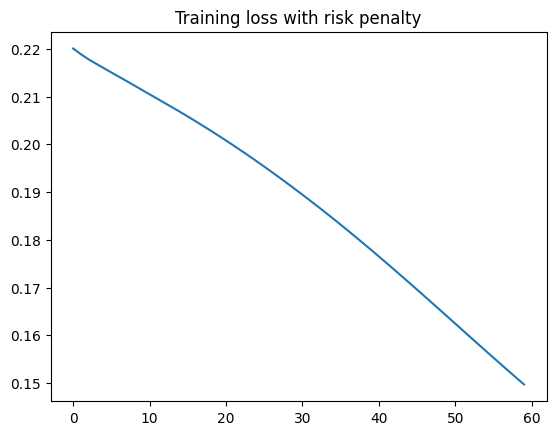

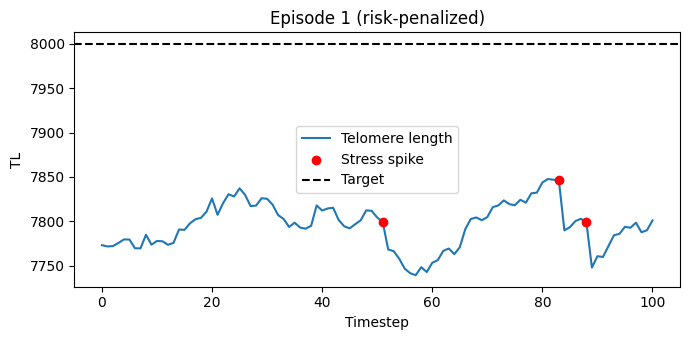

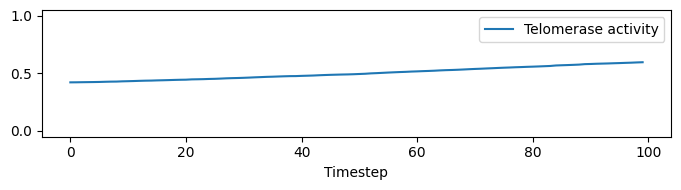

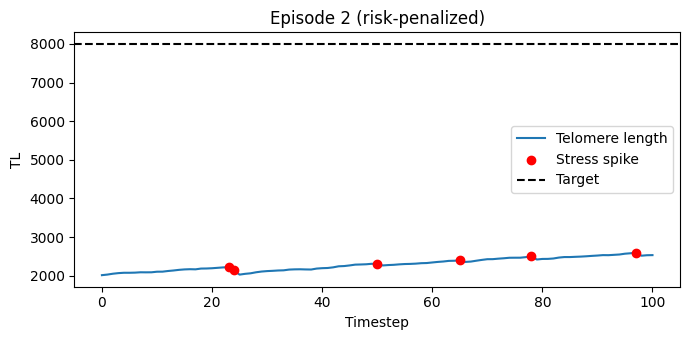

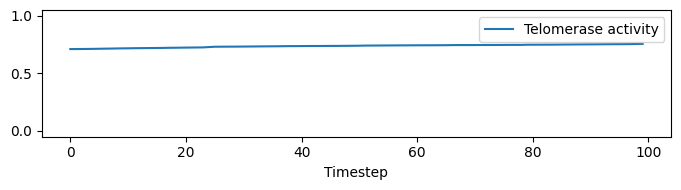

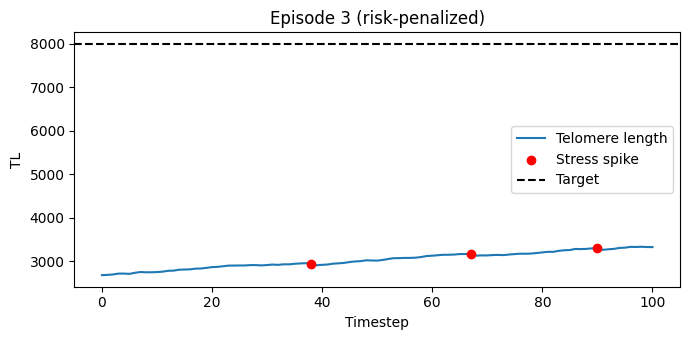

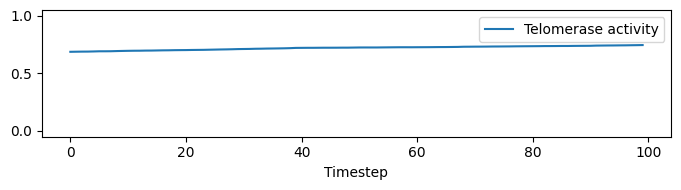

In [ ]:
env = TelomereSimulator()
model, losses = train_controller(env, lambda_penalty=0.1, epochs=60)
plt.plot(losses); plt.title("Training loss with risk penalty"); plt.show()
eval_and_plot(model, env)

Epoch 10: loss=0.23736
Epoch 20: loss=0.22820
Epoch 30: loss=0.21841
Epoch 40: loss=0.20729
Epoch 50: loss=0.19504
Epoch 60: loss=0.18254


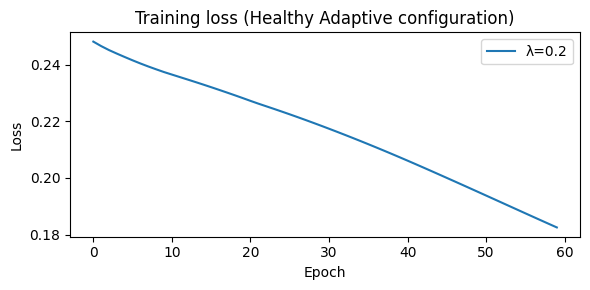

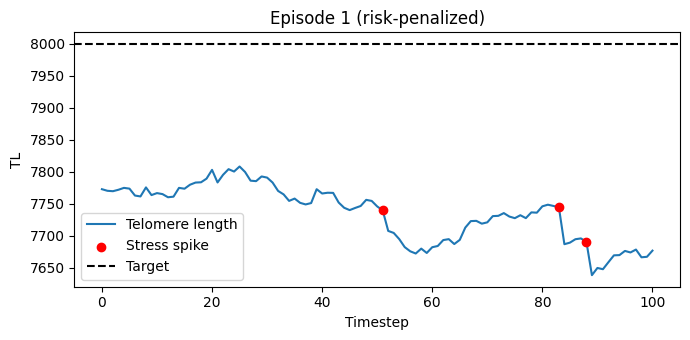

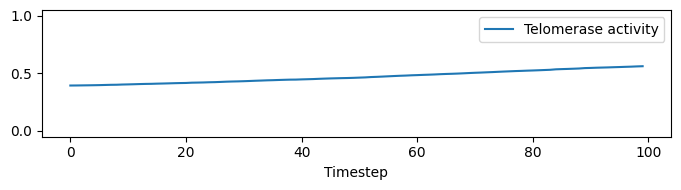

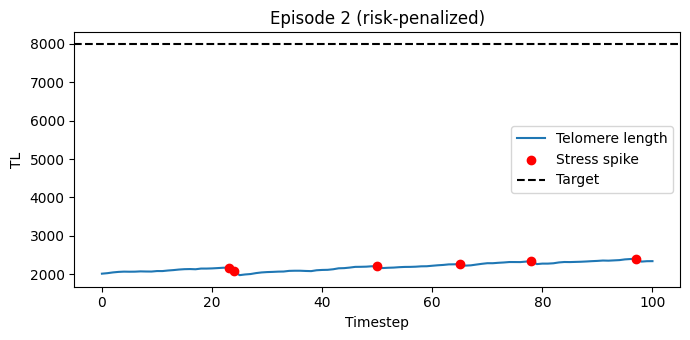

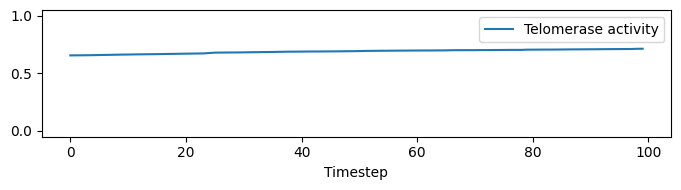

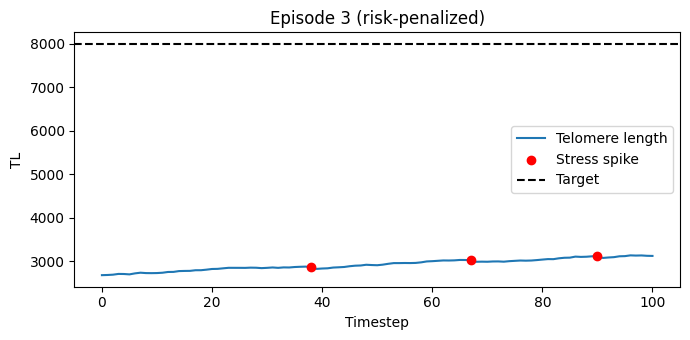

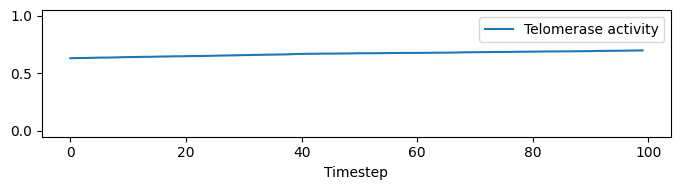

In [ ]:
# --- Healthy adaptive configuration ---
lambda_penalty = 0.2   # moderate oncogenic-risk penalty
teacher_damping = 0.9  # smooth feedback-limited response

# Train controller with the chosen parameters
env = TelomereSimulator()
model, losses = train_controller(env,
                                 lambda_penalty=lambda_penalty,
                                 epochs=60,
                                 lr=1e-3)

# Plot training loss
plt.figure(figsize=(6,3))
plt.plot(losses, label=f"λ={lambda_penalty}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss (Healthy Adaptive configuration)")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate and visualize behavior
eval_and_plot(model, env, n_episodes=3, horizon=100)

Epoch 10: loss=0.21767
Epoch 20: loss=0.20965
Epoch 30: loss=0.20014
Epoch 40: loss=0.18860
Epoch 50: loss=0.17496
Epoch 60: loss=0.15917


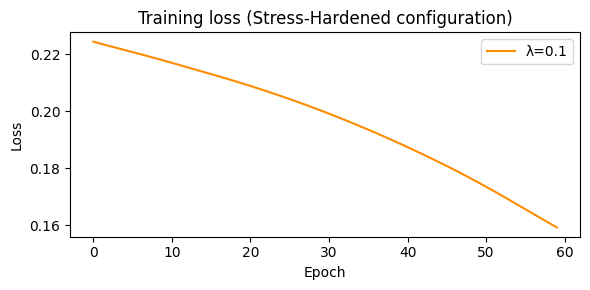

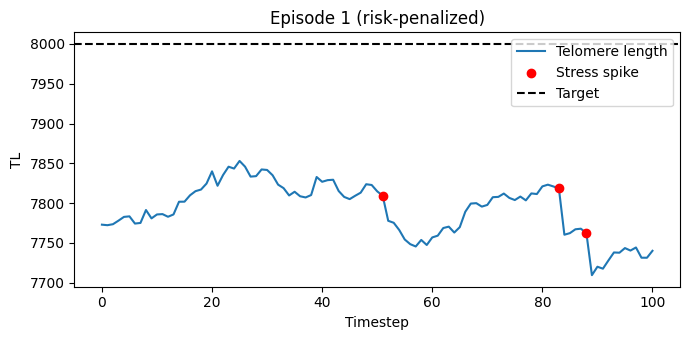

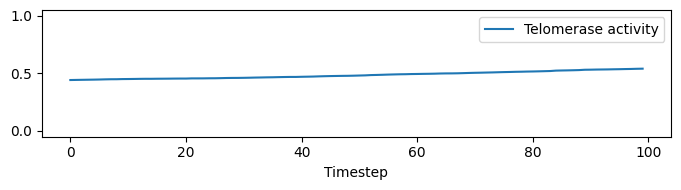

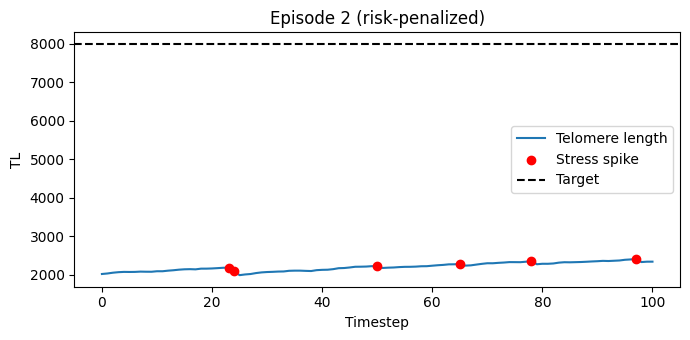

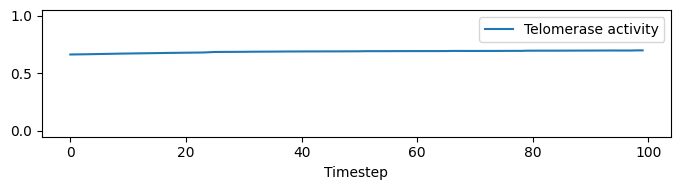

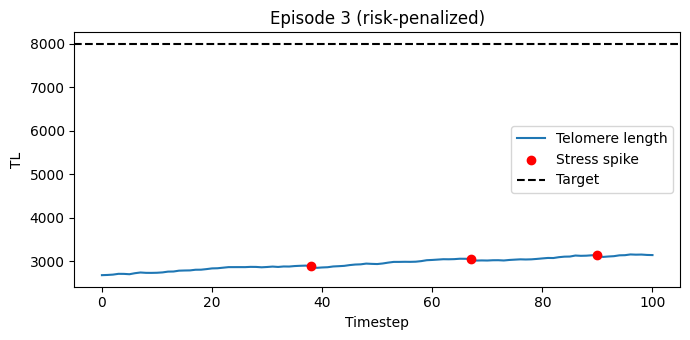

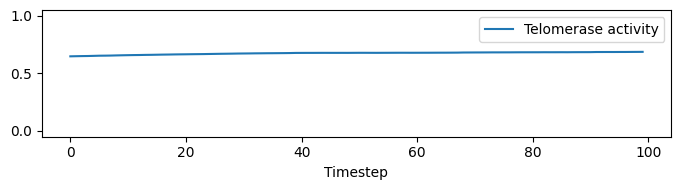

In [ ]:
# --- Stress-hardened configuration ---
lambda_penalty = 0.1   # weaker penalty → more tolerance for sustained telomerase
teacher_damping = 0.8  # faster response → quicker recovery from damage

# Train controller with stress-hardened parameters
env = TelomereSimulator()
model_stress, losses_stress = train_controller(env,
                                               lambda_penalty=lambda_penalty,
                                               epochs=60,
                                               lr=1e-3)

# Plot training loss
plt.figure(figsize=(6,3))
plt.plot(losses_stress, color='darkorange', label=f"λ={lambda_penalty}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss (Stress-Hardened configuration)")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate and visualize
eval_and_plot(model_stress, env, n_episodes=3, horizon=100)

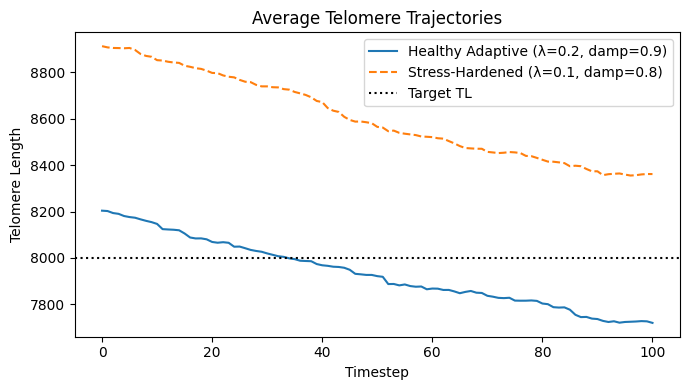

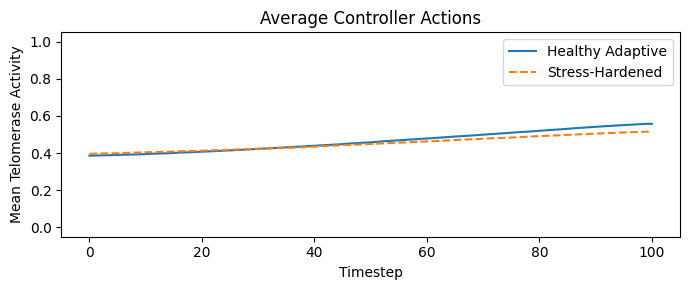

In [ ]:
def compare_controllers(env, model_healthy, model_stress, n_episodes=10, horizon=100):
    def run_avg(model):
        TL_hist, A_hist = [], []
        for _ in range(n_episodes):
            obs = env.reset()
            TLs, As = [env.TL], []
            for _ in range(horizon):
                with torch.no_grad():
                    a = model(torch.from_numpy(obs).unsqueeze(0)).item()
                obs, done, info = env.step(a)
                TLs.append(info["TL"]); As.append(a)
                if done: break
            TL_hist.append(np.array(TLs))
            A_hist.append(np.array(As))
        # align by padding shorter episodes
        maxlen = max(len(t) for t in TL_hist)
        TL_hist = np.array([np.pad(t, (0, maxlen-len(t)), 'edge') for t in TL_hist])
        A_hist = np.array([np.pad(a, (0, maxlen-len(a)), 'edge') for a in A_hist])
        return TL_hist.mean(axis=0), A_hist.mean(axis=0)

    tl_h, a_h = run_avg(model_healthy)
    tl_s, a_s = run_avg(model_stress)

    t = np.arange(len(tl_h))
    plt.figure(figsize=(7,4))
    plt.plot(t, tl_h, label='Healthy Adaptive (λ=0.2, damp=0.9)')
    plt.plot(t, tl_s, label='Stress-Hardened (λ=0.1, damp=0.8)', linestyle='--')
    plt.axhline(env.target_TL, color='k', ls=':', label='Target TL')
    plt.xlabel("Timestep")
    plt.ylabel("Telomere Length")
    plt.title("Average Telomere Trajectories")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,3))
    plt.plot(a_h, label='Healthy Adaptive')
    plt.plot(a_s, label='Stress-Hardened', linestyle='--')
    plt.xlabel("Timestep")
    plt.ylabel("Mean Telomerase Activity")
    plt.title("Average Controller Actions")
    plt.ylim(-0.05, 1.05)
    plt.legend(); plt.tight_layout(); plt.show()

# Run the comparison
compare_controllers(env, model, model_stress, n_episodes=10, horizon=100)

Epoch 10: loss=0.27798
Epoch 20: loss=0.26785
Epoch 30: loss=0.26074
Epoch 40: loss=0.25266
Epoch 50: loss=0.24341
Epoch 60: loss=0.23304


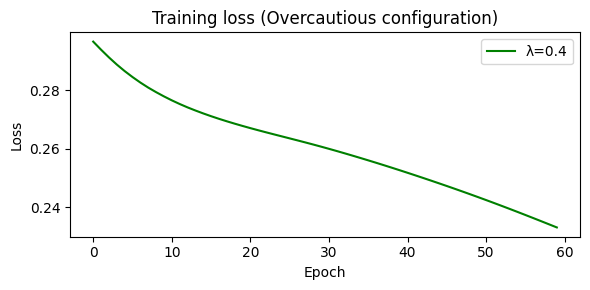

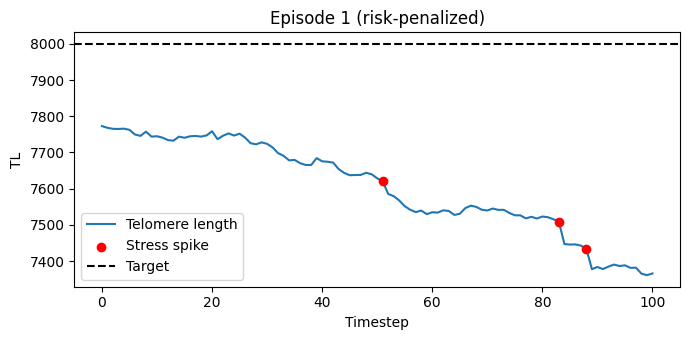

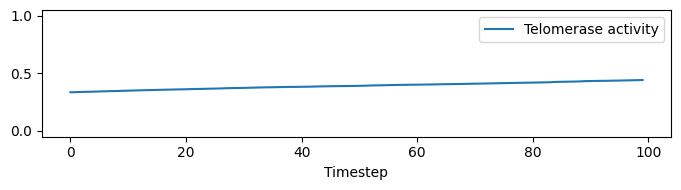

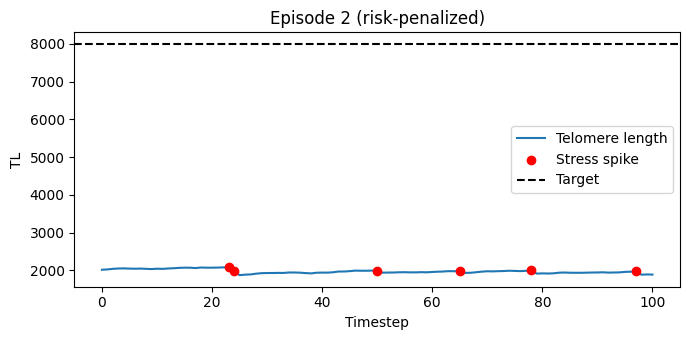

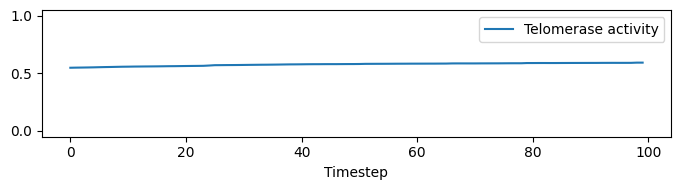

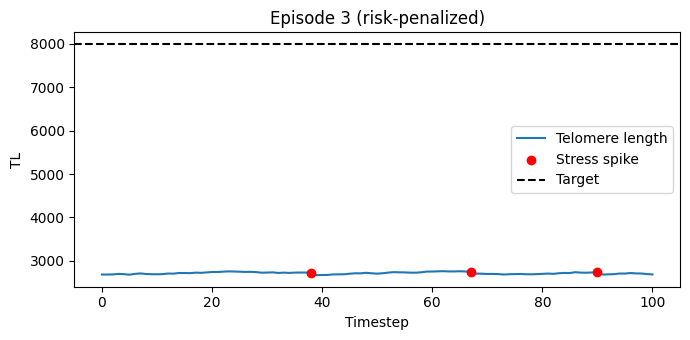

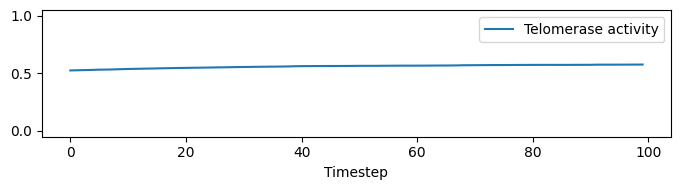

In [ ]:
# --- Overcautious configuration ---
lambda_penalty = 0.4   # strong penalty → strongly avoids sustained telomerase
teacher_damping = 0.95 # very smooth response → sluggish recovery

# Train overcautious controller
env = TelomereSimulator()
model_over, losses_over = train_controller(env,
                                           lambda_penalty=lambda_penalty,
                                           epochs=60,
                                           lr=1e-3)

# Plot loss
plt.figure(figsize=(6,3))
plt.plot(losses_over, color='green', label=f"λ={lambda_penalty}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss (Overcautious configuration)")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate and visualize
eval_and_plot(model_over, env, n_episodes=3, horizon=100)

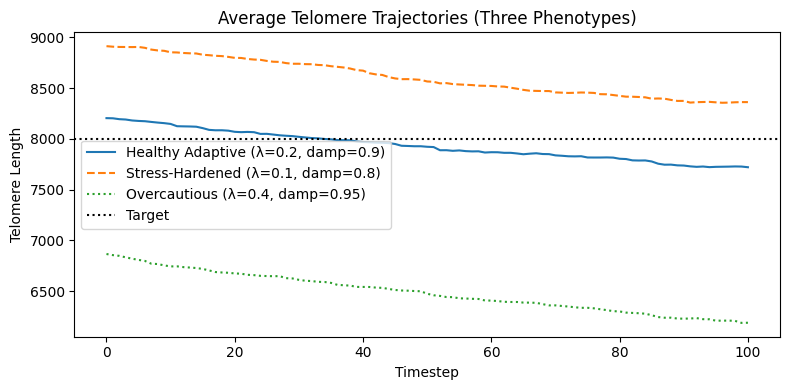

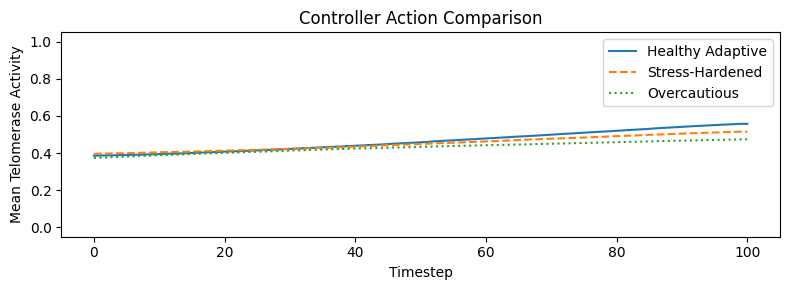

In [ ]:
def compare_three(env, model_healthy, model_stress, model_over, n_episodes=10, horizon=100):
    def run_avg(model):
        TL_hist, A_hist = [], []
        for _ in range(n_episodes):
            obs = env.reset()
            TLs, As = [env.TL], []
            for _ in range(horizon):
                with torch.no_grad():
                    a = model(torch.from_numpy(obs).unsqueeze(0)).item()
                obs, done, info = env.step(a)
                TLs.append(info["TL"]); As.append(a)
                if done: break
            TL_hist.append(np.array(TLs)); A_hist.append(np.array(As))
        maxlen = max(len(t) for t in TL_hist)
        TL_hist = np.array([np.pad(t, (0,maxlen-len(t)),'edge') for t in TL_hist])
        A_hist = np.array([np.pad(a, (0,maxlen-len(a)),'edge') for a in A_hist])
        return TL_hist.mean(axis=0), A_hist.mean(axis=0)

    tl_h, a_h = run_avg(model_healthy)
    tl_s, a_s = run_avg(model_stress)
    tl_o, a_o = run_avg(model_over)

    t = np.arange(len(tl_h))
    plt.figure(figsize=(8,4))
    plt.plot(t, tl_h, label='Healthy Adaptive (λ=0.2, damp=0.9)')
    plt.plot(t, tl_s, '--', label='Stress-Hardened (λ=0.1, damp=0.8)')
    plt.plot(t, tl_o, ':', label='Overcautious (λ=0.4, damp=0.95)')
    plt.axhline(env.target_TL, color='k', ls=':', label='Target')
    plt.xlabel("Timestep"); plt.ylabel("Telomere Length")
    plt.title("Average Telomere Trajectories (Three Phenotypes)")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(8,3))
    plt.plot(a_h, label='Healthy Adaptive')
    plt.plot(a_s, '--', label='Stress-Hardened')
    plt.plot(a_o, ':', label='Overcautious')
    plt.xlabel("Timestep"); plt.ylabel("Mean Telomerase Activity")
    plt.title("Controller Action Comparison")
    plt.ylim(-0.05,1.05); plt.legend(); plt.tight_layout(); plt.show()

# Run tri-phenotype comparison
compare_three(env, model, model_stress, model_over)

Training lambda=0.010 ...
Training lambda=0.028 ...
Training lambda=0.046 ...
Training lambda=0.064 ...
Training lambda=0.082 ...
Training lambda=0.100 ...
Training lambda=0.120 ...
Training lambda=0.174 ...
Training lambda=0.229 ...
Training lambda=0.283 ...
Training lambda=0.337 ...
Training lambda=0.391 ...
Training lambda=0.446 ...
Training lambda=0.500 ...
Results summary:
{'lambda': 0.01, 'mse_error': 0.06021434791359536, 'avg_action': 0.5690044453695373, 'frac_high_action': 0.627}
{'lambda': 0.028000000000000004, 'mse_error': 0.10987503256240638, 'avg_action': 0.5597175432207336, 'frac_high_action': 0.5856}
{'lambda': 0.046000000000000006, 'mse_error': 0.13159584837068244, 'avg_action': 0.6122107903797951, 'frac_high_action': 0.6796000000000001}
{'lambda': 0.064, 'mse_error': 0.12967201859229718, 'avg_action': 0.5663102293798875, 'frac_high_action': 0.5900000000000001}
{'lambda': 0.082, 'mse_error': 0.10762153857859152, 'avg_action': 0.5192966562800805, 'frac_high_action': 0.529

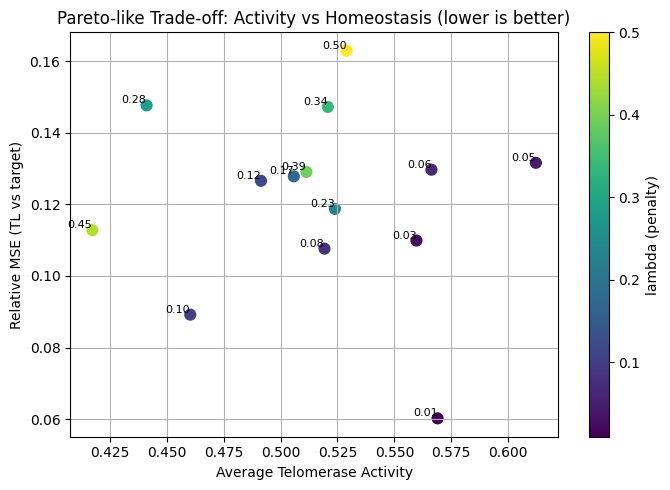

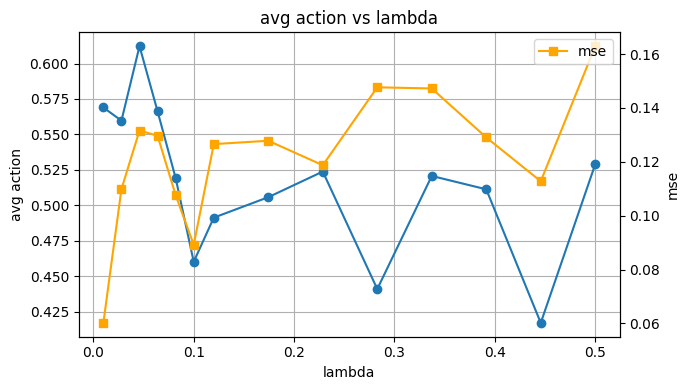

In [ ]:
# multiobjective_pareto.py
# Requires: numpy, torch, matplotlib

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ----- Noisy Telomere Simulator (same as before) -----
class TelomereSimulator:
    def __init__(self, replication_loss=20.0, extension_efficiency=40.0,
                 damage_sigma=6.0, target_TL=8000.0, max_steps=100,
                 spike_prob=0.05, spike_min=30.0, spike_max=120.0,
                 metabolic_noise_sigma=4.0, seed=None):
        self.base_replication_loss = replication_loss
        self.base_extension_efficiency = extension_efficiency
        self.damage_sigma = damage_sigma
        self.target_TL = target_TL
        self.max_steps = max_steps
        self.spike_prob = spike_prob
        self.spike_min = spike_min
        self.spike_max = spike_max
        self.metabolic_noise_sigma = metabolic_noise_sigma
        self.rng = np.random.RandomState(seed) if seed is not None else np.random.RandomState()

    def reset(self, TL_init=None):
        if TL_init is None:
            TL_init = float(self.rng.uniform(2000.0, 12000.0))
        self.TL = TL_init
        self.t = 0
        return np.array([self.TL / 10000.0, self.t / self.max_steps], dtype=np.float32)

    def _get_obs(self):
        return np.array([self.TL / 10000.0, self.t / self.max_steps], dtype=np.float32)

    def step(self, action):
        rep_noise = self.rng.normal(0.0, self.metabolic_noise_sigma)
        ext_noise = self.rng.normal(0.0, self.metabolic_noise_sigma)
        replication_loss = max(0.0, self.base_replication_loss + rep_noise)
        extension_efficiency = max(1e-3, self.base_extension_efficiency + ext_noise)

        a = float(np.clip(action, 0.0, 1.0))
        deterministic = - replication_loss + a * extension_efficiency
        stochastic = float(self.rng.normal(0.0, self.damage_sigma))

        spike = 0.0
        if self.rng.rand() < self.spike_prob:
            spike = float(self.rng.uniform(self.spike_min, self.spike_max))

        self.TL = max(self.TL + deterministic - stochastic - spike, 0.0)
        self.t += 1
        obs = self._get_obs()
        done = (self.t >= self.max_steps)
        info = {"TL": self.TL, "spike": spike}
        return obs, done, info

# ----- Feedforward controller -----
class FeedForwardController(nn.Module):
    def __init__(self, in_dim=2, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, max(8, hidden//2)),
            nn.ReLU(),
            nn.Linear(max(8, hidden//2), 1),
            nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

# ----- Risk-aware teacher for generating supervised targets -----
def risk_aware_teacher_data(env, n_episodes=400, horizon=50, damping=0.9, seed=None):
    rng = np.random.RandomState(seed) if seed is not None else np.random.RandomState()
    X, Y = [], []
    for _ in range(n_episodes):
        obs = env.reset()
        prev_action = 0.0
        for t in range(horizon):
            error = env.target_TL - env.TL
            base_action = np.clip(0.02 * error, 0.0, 1.0)
            action = damping * prev_action + (1 - damping) * base_action
            X.append(obs.copy()); Y.append([action])
            obs, done, _ = env.step(action)
            prev_action = action
            if done: break
    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)

# ----- Train supervised controller with lambda penalty -----
def train_supervised_with_penalty(X, Y, lambda_penalty=0.1, epochs=40, batch_size=256, lr=1e-3, device='cpu'):
    device = torch.device(device)
    model = FeedForwardController().to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    N = X.shape[0]
    for ep in range(epochs):
        idx = np.random.permutation(N)
        running = 0.0
        for start in range(0, N, batch_size):
            batch_idx = idx[start:start+batch_size]
            xb = torch.from_numpy(X[batch_idx]).to(device)
            yb = torch.from_numpy(Y[batch_idx]).to(device)
            pred = model(xb)
            loss = criterion(pred, yb) + lambda_penalty * torch.mean(pred**2)
            opt.zero_grad(); loss.backward(); opt.step()
            running += loss.item() * xb.shape[0]
    return model

# ----- Evaluation metrics -----
def evaluate_controller_metrics(env, model, n_episodes=50, horizon=100, action_threshold=0.5):
    metrics = {"mse_error": [], "avg_action": [], "frac_high_action": []}
    target = env.target_TL
    for ep in range(n_episodes):
        obs = env.reset()
        TLs, As = [], []
        for t in range(horizon):
            with torch.no_grad():
                a = model(torch.from_numpy(obs).unsqueeze(0)).cpu().numpy().ravel()[0]
            obs, done, info = env.step(a)
            TLs.append(info["TL"]); As.append(a)
            if done: break
        TLs = np.array(TLs); As = np.array(As)
        mse = np.mean(((TLs - target)/target)**2)   # relative MSE
        avg_a = float(np.mean(As))
        frac = float(np.mean(As > action_threshold))
        metrics["mse_error"].append(mse); metrics["avg_action"].append(avg_a); metrics["frac_high_action"].append(frac)
    # aggregate across episodes
    return {k: float(np.mean(v)) for k,v in metrics.items()}

# ----- Pareto sweep routine -----
def pareto_sweep(lambda_values=None, damping=0.9, teacher_seed=0, env_seed=None,
                 train_epochs=40, n_eval=50):
    if lambda_values is None:
        lambda_values = np.concatenate([np.linspace(0.01, 0.1, 5), np.linspace(0.12, 0.5, 8)])
    results = []
    # Use a single environment instance for data gen, then separate env for evaluation (randomized)
    data_env = TelomereSimulator(seed=teacher_seed)
    X_base, Y_base = risk_aware_teacher_data(data_env, n_episodes=400, horizon=50, damping=damping, seed=teacher_seed)
    for lam in lambda_values:
        print(f"Training lambda={lam:.3f} ...")
        model = train_supervised_with_penalty(X_base, Y_base, lambda_penalty=lam, epochs=train_epochs)
        # evaluate on a fresh env per lam (randomized)
        eval_env = TelomereSimulator(seed=None) if env_seed is None else TelomereSimulator(seed=env_seed+int(lam*1000))
        metrics = evaluate_controller_metrics(eval_env, model, n_episodes=n_eval, horizon=100)
        results.append({"lambda": float(lam), **metrics})
    return results

# ----- Plotting Pareto front -----
def plot_pareto(results):
    lambdas = [r["lambda"] for r in results]
    mse = [r["mse_error"] for r in results]
    avg_action = [r["avg_action"] for r in results]
    frac_high = [r["frac_high_action"] for r in results]

    plt.figure(figsize=(7,5))
    sc = plt.scatter(avg_action, mse, c=lambdas, cmap='viridis', s=60)
    for i, lam in enumerate(lambdas):
        plt.text(avg_action[i], mse[i], f"{lam:.2f}", fontsize=8, ha='right', va='bottom')
    plt.colorbar(sc, label='lambda (penalty)')
    plt.xlabel("Average Telomerase Activity")
    plt.ylabel("Relative MSE (TL vs target)")
    plt.title("Pareto-like Trade-off: Activity vs Homeostasis (lower is better)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # optionally plot high-action fraction vs mse
    plt.figure(figsize=(7,4))
    plt.plot(lambdas, avg_action, '-o', label='avg action'); plt.xlabel('lambda'); plt.ylabel('avg action'); plt.title('avg action vs lambda'); plt.grid(True)
    plt.twinx(); plt.plot(lambdas, mse, '-s', color='orange', label='mse'); plt.ylabel('mse'); plt.legend(loc='upper right')
    plt.tight_layout(); plt.show()

# ----- Example usage (if run as script) -----
if __name__ == '__main__':
    lambdas = np.concatenate([np.linspace(0.01, 0.1, 6), np.linspace(0.12, 0.5, 8)])
    results = pareto_sweep(lambda_values=lambdas, damping=0.9, train_epochs=40, n_eval=50)
    print("Results summary:")
    for r in results:
        print(r)
    plot_pareto(results)

λ=0.050, damp=0.750 → MSE=0.1105, AvgAct=0.639, HighAct=0.656
λ=0.050, damp=0.794 → MSE=0.1121, AvgAct=0.577, HighAct=0.575
λ=0.050, damp=0.838 → MSE=0.1146, AvgAct=0.580, HighAct=0.589
λ=0.050, damp=0.882 → MSE=0.1188, AvgAct=0.567, HighAct=0.577
λ=0.050, damp=0.926 → MSE=0.1280, AvgAct=0.530, HighAct=0.551
λ=0.050, damp=0.970 → MSE=0.1528, AvgAct=0.452, HighAct=0.510
λ=0.100, damp=0.750 → MSE=0.1155, AvgAct=0.534, HighAct=0.525
λ=0.100, damp=0.794 → MSE=0.1136, AvgAct=0.577, HighAct=0.588
λ=0.100, damp=0.838 → MSE=0.1221, AvgAct=0.541, HighAct=0.601
λ=0.100, damp=0.882 → MSE=0.1253, AvgAct=0.517, HighAct=0.528
λ=0.100, damp=0.926 → MSE=0.1314, AvgAct=0.541, HighAct=0.605
λ=0.100, damp=0.970 → MSE=0.1569, AvgAct=0.411, HighAct=0.461
λ=0.150, damp=0.750 → MSE=0.1198, AvgAct=0.542, HighAct=0.593
λ=0.150, damp=0.794 → MSE=0.1226, AvgAct=0.513, HighAct=0.539
λ=0.150, damp=0.838 → MSE=0.1242, AvgAct=0.530, HighAct=0.583
λ=0.150, damp=0.882 → MSE=0.1272, AvgAct=0.528, HighAct=0.583
λ=0.150,

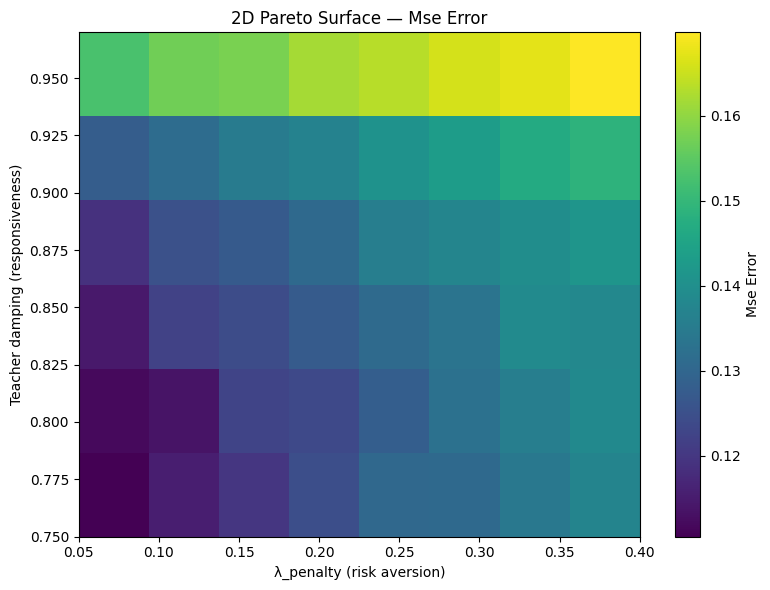

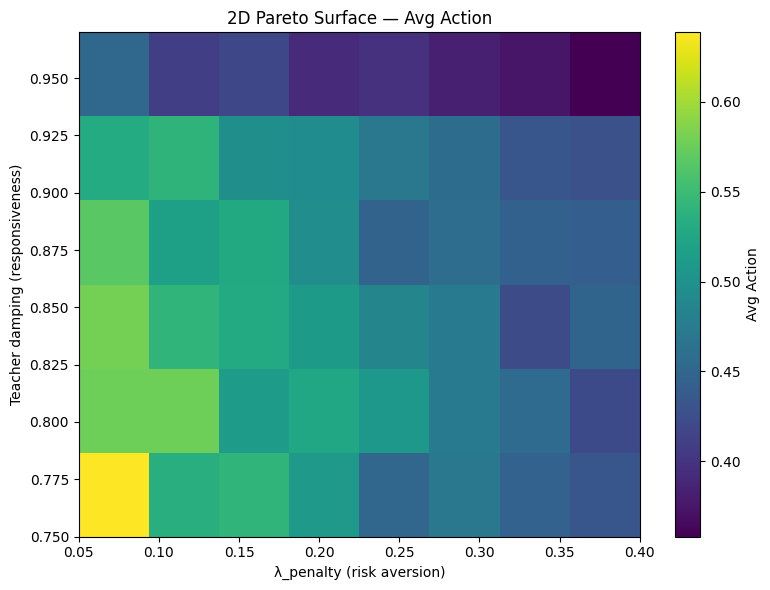

In [ ]:
# --- 2D Pareto Sweep for Multiobjective Optimization ---

def pareto_sweep_2D(lambda_values=None, damping_values=None,
                    train_epochs=40, n_eval=40, teacher_seed=0):
    if lambda_values is None:
        lambda_values = np.linspace(0.05, 0.5, 10)
    if damping_values is None:
        damping_values = np.linspace(0.7, 0.98, 8)

    results = []
    for lam in lambda_values:
        for damp in damping_values:
            env = TelomereSimulator(seed=teacher_seed)
            X_base, Y_base = risk_aware_teacher_data(env, n_episodes=400, horizon=50, damping=damp)
            model = train_supervised_with_penalty(X_base, Y_base,
                                                  lambda_penalty=lam,
                                                  epochs=train_epochs)
            metrics = evaluate_controller_metrics(env, model, n_episodes=n_eval, horizon=100)
            results.append({
                "lambda": lam,
                "damping": damp,
                **metrics
            })
            print(f"λ={lam:.3f}, damp={damp:.3f} → MSE={metrics['mse_error']:.4f}, "
                  f"AvgAct={metrics['avg_action']:.3f}, HighAct={metrics['frac_high_action']:.3f}")
    return results


# --- Visualization: 2D Heatmaps (Pareto surface) ---
def plot_pareto_2D(results, variable="mse_error"):
    import pandas as pd
    df = pd.DataFrame(results)
    lambdas = sorted(df["lambda"].unique())
    damps = sorted(df["damping"].unique())
    M = np.zeros((len(damps), len(lambdas)))
    for i, d in enumerate(damps):
        for j, l in enumerate(lambdas):
            M[i,j] = df[(df["lambda"]==l) & (df["damping"]==d)][variable].values[0]

    plt.figure(figsize=(8,6))
    plt.imshow(M, origin='lower', aspect='auto',
               extent=[min(lambdas), max(lambdas), min(damps), max(damps)],
               cmap='viridis')
    plt.colorbar(label=variable.replace("_", " ").title())
    plt.xlabel("λ_penalty (risk aversion)")
    plt.ylabel("Teacher damping (responsiveness)")
    plt.title(f"2D Pareto Surface — {variable.replace('_', ' ').title()}")
    plt.tight_layout()
    plt.show()


# --- Example run ---
if __name__ == "__main__":
    lambdas = np.linspace(0.05, 0.4, 8)
    damps = np.linspace(0.75, 0.97, 6)
    results_2d = pareto_sweep_2D(lambda_values=lambdas, damping_values=damps,
                                 train_epochs=30, n_eval=30)
    plot_pareto_2D(results_2d, variable="mse_error")
    plot_pareto_2D(results_2d, variable="avg_action")

In [ ]:
# --- Enhanced 2D Pareto Sweep with Frontier Extraction ---

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Pareto sweep (same core as before) ---
def pareto_sweep_2D(lambda_values=None, damping_values=None,
                    train_epochs=40, n_eval=40, teacher_seed=0):
    if lambda_values is None:
        lambda_values = np.linspace(0.05, 0.5, 10)
    if damping_values is None:
        damping_values = np.linspace(0.7, 0.98, 8)

    results = []
    for lam in lambda_values:
        for damp in damping_values:
            env = TelomereSimulator(seed=teacher_seed)
            X_base, Y_base = risk_aware_teacher_data(env, n_episodes=400, horizon=50, damping=damp)
            model = train_supervised_with_penalty(X_base, Y_base,
                                                  lambda_penalty=lam,
                                                  epochs=train_epochs)
            metrics = evaluate_controller_metrics(env, model, n_episodes=n_eval, horizon=100)
            results.append({
                "lambda": lam,
                "damping": damp,
                **metrics
            })
            print(f"λ={lam:.3f}, damp={damp:.3f} → MSE={metrics['mse_error']:.4f}, "
                  f"AvgAct={metrics['avg_action']:.3f}, HighAct={metrics['frac_high_action']:.3f}")
    return pd.DataFrame(results)


# --- Non-dominated sorting (Pareto frontier extraction) ---
def pareto_front(df, obj1="mse_error", obj2="avg_action"):
    # lower is better for both objectives
    pts = df[[obj1, obj2]].values
    is_dominated = np.zeros(len(pts), dtype=bool)
    for i, p in enumerate(pts):
        if any(((q[0] <= p[0] and q[1] <= p[1]) and (q[0] < p[0] or q[1] < p[1])) for q in pts):
            is_dominated[i] = True
    frontier = df[~is_dominated].sort_values(by=obj1)
    return frontier


# --- Plot Pareto front and 2D results ---
def plot_pareto_front(df, obj1="mse_error", obj2="avg_action"):
    frontier = pareto_front(df, obj1=obj1, obj2=obj2)
    plt.figure(figsize=(7,5))
    plt.scatter(df[obj2], df[obj1], c=df["lambda"], cmap="viridis", alpha=0.6, label="All models")
    plt.plot(frontier[obj2], frontier[obj1], "-o", color="red", label="Pareto frontier", linewidth=2)
    for i, row in frontier.iterrows():
        plt.text(row[obj2], row[obj1], f"λ={row['lambda']:.2f}\nγ={row['damping']:.2f}",
                 fontsize=7, ha="right", va="bottom")
    plt.xlabel("Average Telomerase Activity (lower = safer)")
    plt.ylabel("Telomere Error (lower = stable)")
    plt.title("Pareto Frontier — Stability vs Energy Cost")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()
    return frontier


# --- Heatmap utility for context ---
def plot_pareto_2D(df, variable="mse_error"):
    lambdas = sorted(df["lambda"].unique())
    damps = sorted(df["damping"].unique())
    M = np.zeros((len(damps), len(lambdas)))
    for i, d in enumerate(damps):
        for j, l in enumerate(lambdas):
            val = df[(df["lambda"]==l) & (df["damping"]==d)][variable].values
            if len(val)>0: M[i,j] = val[0]
            else: M[i,j] = np.nan
    plt.figure(figsize=(8,6))
    plt.imshow(M, origin='lower', aspect='auto',
               extent=[min(lambdas), max(lambdas), min(damps), max(damps)],
               cmap='viridis')
    plt.colorbar(label=variable.replace("_", " ").title())
    plt.xlabel("λ_penalty (risk aversion)")
    plt.ylabel("Teacher damping (responsiveness)")
    plt.title(f"2D Pareto Surface — {variable.replace('_', ' ').title()}")
    plt.tight_layout()
    plt.show()


# --- Example run ---
if __name__ == "__main__":
    lambdas = np.linspace(0.05, 0.4, 8)
    damps = np.linspace(0.75, 0.97, 6)
    results_2d = pareto_sweep_2D(lambda_values=lambdas,
                                 damping_values=damps,
                                 train_epochs=30,
                                 n_eval=30)
    plot_pareto_2D(results_2d, variable="mse_error")
    plot_pareto_2D(results_2d, variable="avg_action")

    frontier_df = plot_pareto_front(results_2d)
    print("\n🧠 Optimal trade-off configurations:")
    print(frontier_df[["lambda", "damping", "mse_error", "avg_action", "frac_high_action"]])

λ=0.050, damp=0.750 → MSE=0.1107, AvgAct=0.595, HighAct=0.614
λ=0.050, damp=0.794 → MSE=0.1118, AvgAct=0.570, HighAct=0.547
λ=0.050, damp=0.838 → MSE=0.1146, AvgAct=0.583, HighAct=0.599
λ=0.050, damp=0.882 → MSE=0.1187, AvgAct=0.561, HighAct=0.548
λ=0.050, damp=0.926 → MSE=0.1298, AvgAct=0.530, HighAct=0.561
λ=0.050, damp=0.970 → MSE=0.1533, AvgAct=0.434, HighAct=0.485
λ=0.100, damp=0.750 → MSE=0.1175, AvgAct=0.548, HighAct=0.577
λ=0.100, damp=0.794 → MSE=0.1206, AvgAct=0.514, HighAct=0.597
λ=0.100, damp=0.838 → MSE=0.1214, AvgAct=0.545, HighAct=0.584
λ=0.100, damp=0.882 → MSE=0.1233, AvgAct=0.588, HighAct=0.633
λ=0.100, damp=0.926 → MSE=0.1318, AvgAct=0.517, HighAct=0.555
λ=0.100, damp=0.970 → MSE=0.1557, AvgAct=0.437, HighAct=0.491
λ=0.150, damp=0.750 → MSE=0.1201, AvgAct=0.561, HighAct=0.622
λ=0.150, damp=0.794 → MSE=0.1246, AvgAct=0.446, HighAct=0.476
λ=0.150, damp=0.838 → MSE=0.1268, AvgAct=0.500, HighAct=0.546
λ=0.150, damp=0.882 → MSE=0.1277, AvgAct=0.506, HighAct=0.533
λ=0.150,